#Εισαγωγή

##Στοιχεία ομάδας

**Ομάδα 46**

**Ακαρέπης Ανδρέας** - ΑΜ: 03117058  
**Γιαννόπουλος Εμμανουήλ** - ΑΜ: 03117031  
**Κόντη Πολυξένη-Ειρήνη** - ΑΜ: 03117180

Imports, επαναχρησιμοποιούμενες συναρτήσεις και μερικές παρατηρήσεις.

**Σημείωση:** Αν το notebook ανοιχτεί σε Google Colab, τα διαγράμματα φαίνονται αρκετά καλύτερα στο light theme σε σχέση με το dark theme. Αυτό πιθανότατα θα ισχύει και για οποιοδήποτε άλλο περιβάλλον περιλαμβάνει dark και light themes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
import copy


from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Check if a dataset is balanced or not
def check_balance(labels):
  for key, value in collections.Counter(labels).items():
    print(key, ": ", value, " - ", round(value/len(labels)*100), '%', sep='')

#To print confusion matrices and f1 averages
def plot_confusion_matrix_and_scores(predictions, test_labels, disp_labels=[0,1]):
  labels = disp_labels
  for name, preds in predictions.items():
    conf_matrix = confusion_matrix(test_labels, preds, labels)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    disp.plot()
    disp.ax_.set_title(name)
    print("\nf1-micro average for", name, ":", f1_score(test_labels, preds, average='micro'))
    print("f1-macro average for", name, ":",f1_score(test_labels, preds, average='macro'))
    print("Classification report:")
    print(classification_report(test_labels, preds))
    plt.show()
    print('-'*60)

#Printing our bar plots
def print_bar_plots(predictions, test_labels, avg, size=(10,10), rot=30):
    fig = plt.figure(figsize=size)
    titl = 'f1-'+avg+' average'
    names = []
    scores = []
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(titl)
    plt.xticks(rotation=rot)
    for name, preds in predictions.items():
      names.append(name)
      scores.append(f1_score(test_labels, preds, average=avg))
    ax.bar(names,scores)
    plt.show()

#Function to print an entire dataframe
def print_full(df):
    pd.set_option('display.max_rows', len(df))
    pd.set_option('display.max_columns', len(df.iloc[0]))
    print(df)

#Function to train and test a classifier given a ready grid search result
def train_best_time_and_predict(grid_result, train, train_labels, test):
    clf = grid_result.best_estimator_
    start_time = time.time()
    clf.fit(train, train_labels)
    predictions = clf.predict(test)
    total_time = time.time()-start_time
    return predictions, total_time    

#Get a dictionary of predictions, return scores
#Used when we compare before-after optimization scores
def change_preds_to_scores(d, test_labels, avg):
    for key,value in d.items():
        for i in range(3):
          d[key][i] = f1_score(d[key][i], test_labels, average=avg)
    


## Προσέγγιση στα GridSearchCV 
Επειδή στο notebook καταγράφονται μόνο τα τελικά αποτελέσματα των GridSearchCV που οδήγησαν στους τελικούς επιλεγμένους ταξινομητές (τα υπόλοιπα απλά αναλύονται), δείχνουμε ένα παράδειγμα της προσέγγισής μας όσον αφορά στην καταγραφή των αποτελεσμάτων των διάφορων GridSearchCV που εκτελέσαμε. Συγκεκριμένα, καταγράφουμε για κάθε διασταυρούμενη επικύρωση πλέγματος όλα τα αποτελέσματα ταξινομημένα ως προς την μετρική που χρησιμοποιούμε, ώστε να έχουμε μια γενικότερη εικόνα για την επίδοση των παραμέτρων και όχι μόνο για τη βέλτιστη παραμετροποίηση. Με αυτό τον τρόπο, μπορούμε να δούμε αν κάποια τιμή μιας παραμέτρου υπερτερεί σταθερά των υπόλοιπων.  

Στο παρακάτω GridSearch για παράδειγμα βλέπουμε ότι ο solver *adam* ειναι σταθερά καλύτερος από τον solver *sgd*, καθώς και ότι οι activation συναρτήσεις *relu*, *tanh* και *logistic* έχουν σταθερά πολύ καλύτερη απόδοση από τη συνάρτηση *identity*. 

In [ ]:
#Example GridSearchCV on a MLP

#Some preprocessing steps
scaler = StandardScaler()
rus = RandomUnderSampler() 
pca = PCA()
clf = MLPClassifier(hidden_layer_sizes=100, learning max_iter=100)

activators = ['logistic', 'relu', 'tanh', 'identity']
solvers = ['adam', 'sgd']
#Learning rate is only used when solver=sgd
lr = ['invscaling', 'constant', 'adaptive']

parameters = {
    'mlp__activation' : activators,
    'mlp__solver' : solvers,
    'mlp__learning_rate': lr
}
example_pipe = Pipeline(steps=[('scaler', scaler), ('sampler', rus), ('pca', pca), ('mlp', clf)], memory = 'tmp')
example_gscv = GridSearchCV(example_pipe, parameters, cv=5, scoring='f1_micro', verbose=False, n_jobs=-1)
example_gscv.fit(train, train_labels);

df = pd.concat([pd.DataFrame(example_gscv.cv_results_["params"]),pd.DataFrame(example_gscv.cv_results_["mean_test_score"], columns=['accuracy'])],axis=1)
df = df.sort_values(by=['accuracy'])
print_full(df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


   mlp__activation mlp__learning_rate mlp__solver  accuracy
1         logistic         invscaling         sgd  0.465289
7             relu         invscaling         sgd  0.581793
13            tanh         invscaling         sgd  0.695203
19        identity         invscaling         sgd  0.749739
3         logistic           constant         sgd  0.782635
5         logistic           adaptive         sgd  0.782710
18        identity         invscaling        adam  0.783311
22        identity           adaptive        adam  0.783611
23        identity           adaptive         sgd  0.783987
21        identity           constant         sgd  0.784663
20        identity           constant        adam  0.784738
15            tanh           constant         sgd  0.788794
17            tanh           adaptive         sgd  0.789094
11            relu           adaptive         sgd  0.825823
9             relu           constant         sgd  0.826574
0         logistic         invscaling   

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Μέρος 1ο (small dataset)


## Βασικές πληροφορίες
1. Το μικρό dataset περιλαμβάνει τις μετρήσεις 287 κολποσκοπήσεων και γνώμες ειδικών (καθώς και μια μέση γνώμη) που κατατάσσουν κάθε κολποσκόπηση ως **υγιή** ή **μη υγιή**.

2. Αριθμός δειγμάτων: 287  
Αριθμός χαρακτηριστικών: 69 εκ των οποίων τα 7 είναι target.  
Εμείς θα κρατήσουμε μόνο το consensus ως target variable, επομένως έχουμε 62 χαρακτηριστικά που βοηθούν στην πρόβλεψη και 1 χαρακτηριστικό-στόχο

3. Υπάρχουν επικεφαλίδες, δεν υπάρχει αρίθμηση γραμμών (παρακάτω αριθμεί τις γραμμές το pandas).

4. Οι ετικέτες των κλάσεων είναι 0 και 1 και βρίσκονται στην κολόνα 68: consensus (με αρίθμηση από το 0).

5. Συγχωνεύσαμε τα 3 αρχεία csv που δόθηκαν. Οι υπόλοιπες "μετατροπές" γίνονται μέσω του pandas και αφού φορτώσουμε το τελικό αρχείο csv.

6. Δεν υπάρχουν απουσιάζουσες τιμές.

7. Υπάρχουν 2 κλάσεις, η κλάση **υγιής** (1) και η κλάση **μη υγιής** (0). Το ποσοστό των 2 κλάσεων είναι 75-25 με την πλειονότητα των δειγμάτων να κατατάσσονται στην κλάση **1**. Επομένως το dataset είναι **μη ισορροπημένο**. Το φαινόμενο αυτό αντιμετωπίστηκε διαφορετικά για κάθε ταξινομητή και αναλύονται οι επιλογές μας ξεχωριστά παρακάτω.


8. Ο διαχωρισμός σε train,test φαίνεται παρακάτω.



In [ ]:
#Import dataset and separate labels from features
df = pd.read_csv("colpodata.csv")
df

,cervix_area,os_area,...,experts::5,consensus
0,0.344647,0.003080,...,1.0,1.0
1,0.165329,0.000000,...,0.0,0.0
2,0.457010,0.001681,...,0.0,0.0
3,0.513244,0.005711,...,1.0,1.0
4,0.390319,0.009454,...,1.0,1.0
...,...,...,...,...,...
282,0.610160,0.002726,...,0.0,0.0
283,0.439891,0.006005,...,0.0,1.0
284,0.696616,0.006693,...,0.0,1.0
285,1.000000,0.000000,...,0.0,0.0


In [ ]:
labels_df = df.iloc[:, -1]
#Labels are given as floats (0.0, 1.0) so we transform them to binary (0,1)
labels = labels_df.values.astype(int)

features_df = df.iloc[:, :-1]
features = features_df.values

#Dataset is imbalanced (75%-25%). Majority class: 1
check_balance(labels)

#Split data
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.2)

1: 216 - 75%
0: 71 - 25%


## Baseline Classification

### Dummy Classifiers


f1-micro average for Dummy uniform : 0.4827586206896552
f1-macro average for Dummy uniform : 0.45962732919254656
Classification report:
              precision    recall  f1-score   support

           0       0.27      0.50      0.35        16
           1       0.71      0.48      0.57        42

    accuracy                           0.48        58
   macro avg       0.49      0.49      0.46        58
weighted avg       0.59      0.48      0.51        58



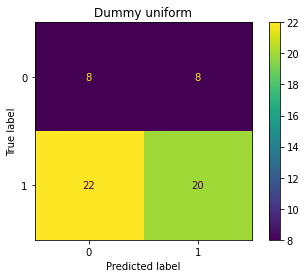

------------------------------------------------------------

f1-micro average for Dummy constant 0 : 0.27586206896551724
f1-macro average for Dummy constant 0 : 0.2162162162162162
Classification report:
              precision    recall  f1-score   support

           0       0.28      1.00      0.43        16
           1       0.00      0.00      0.00        42

    accuracy                           0.28        58
   macro avg       0.14      0.50      0.22        58
weighted avg       0.08      0.28      0.12        58



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


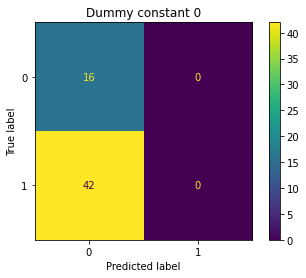

------------------------------------------------------------

f1-micro average for Dummy constant 1 : 0.7241379310344829
f1-macro average for Dummy constant 1 : 0.42000000000000004
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.72      1.00      0.84        42

    accuracy                           0.72        58
   macro avg       0.36      0.50      0.42        58
weighted avg       0.52      0.72      0.61        58



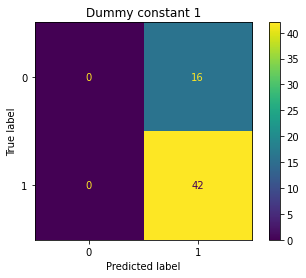

------------------------------------------------------------

f1-micro average for Dummy most frequent : 0.7241379310344829
f1-macro average for Dummy most frequent : 0.42000000000000004
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.72      1.00      0.84        42

    accuracy                           0.72        58
   macro avg       0.36      0.50      0.42        58
weighted avg       0.52      0.72      0.61        58



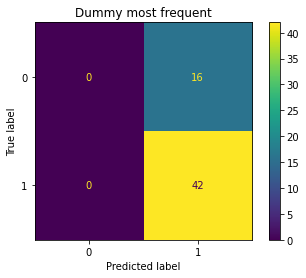

------------------------------------------------------------

f1-micro average for Dummy stratified : 0.6206896551724138
f1-macro average for Dummy stratified : 0.48214285714285715
Classification report:
              precision    recall  f1-score   support

           0       0.25      0.19      0.21        16
           1       0.72      0.79      0.75        42

    accuracy                           0.62        58
   macro avg       0.48      0.49      0.48        58
weighted avg       0.59      0.62      0.60        58



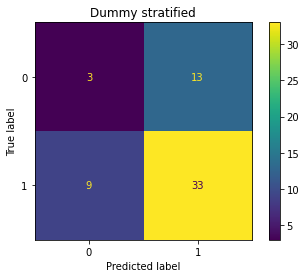

------------------------------------------------------------


In [ ]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_0 = DummyClassifier(strategy="constant", constant=0)
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

dc_uniform.fit(train, train_labels)
dc_constant_0.fit(train, train_labels)
dc_constant_1.fit(train, train_labels)
dc_most_frequent.fit(train, train_labels)
dc_stratified.fit(train, train_labels)

dc_uniform_preds = dc_uniform.predict(test)
dc_constant_0_preds = dc_constant_0.predict(test)
dc_constant_1_preds = dc_constant_1.predict(test)
dc_most_frequent_preds = dc_most_frequent.predict(test)
dc_stratified_preds = dc_stratified.predict(test)


dc_predictions = {
    'Dummy uniform': dc_uniform_preds, 
    'Dummy constant 0': dc_constant_0_preds, 
    'Dummy constant 1': dc_constant_1_preds, 
    'Dummy most frequent' : dc_most_frequent_preds, 
    'Dummy stratified' : dc_stratified_preds
}

plot_confusion_matrix_and_scores(dc_predictions,test_labels)

### Baseline Gaussian Naive Bayes


f1-micro average for Baseline Gaussian Naive Bayes : 0.8275862068965517
f1-macro average for Baseline Gaussian Naive Bayes : 0.7751937984496124
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.86      0.90      0.88        42

    accuracy                           0.83        58
   macro avg       0.79      0.76      0.78        58
weighted avg       0.82      0.83      0.82        58



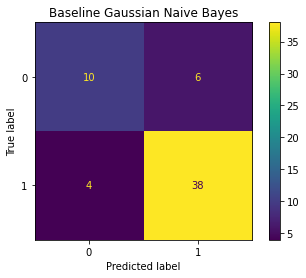

------------------------------------------------------------


In [ ]:
gnb_base = GaussianNB()
gnb_base.fit(train, train_labels)
gnb_base_preds = gnb_base.predict(test)

gnb_base_predictions = {
    'Baseline Gaussian Naive Bayes' : gnb_base_preds
}

plot_confusion_matrix_and_scores(gnb_base_predictions,test_labels)

### Baseline kNN


f1-micro average for Baseline kNN : 0.7413793103448276
f1-macro average for Baseline kNN : 0.5932678821879382
Classification report:
              precision    recall  f1-score   support

           0       0.57      0.25      0.35        16
           1       0.76      0.93      0.84        42

    accuracy                           0.74        58
   macro avg       0.67      0.59      0.59        58
weighted avg       0.71      0.74      0.70        58



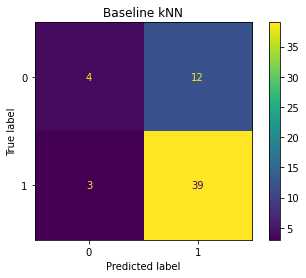

------------------------------------------------------------


In [ ]:
knn_base = KNeighborsClassifier()
knn_base.fit(train, train_labels)
knn_base_preds = knn_base.predict(test)

knn_base_predictions = {
    'Baseline kNN' : knn_base_preds
}
plot_confusion_matrix_and_scores(knn_base_predictions,test_labels)

### Αποτελέσματα και σχολιασμός Baseline ταξινόμησης

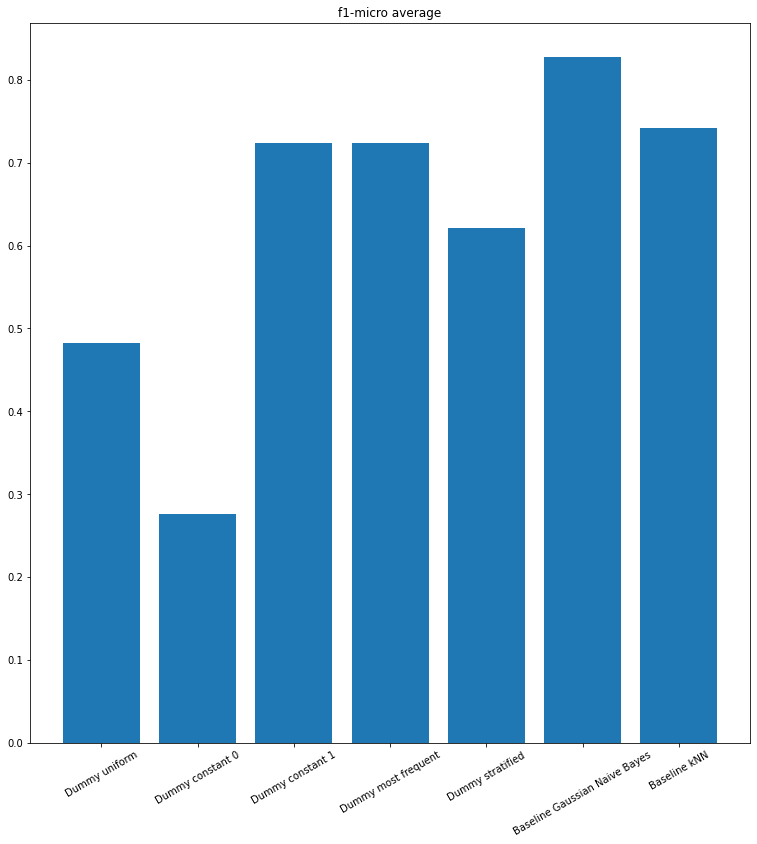

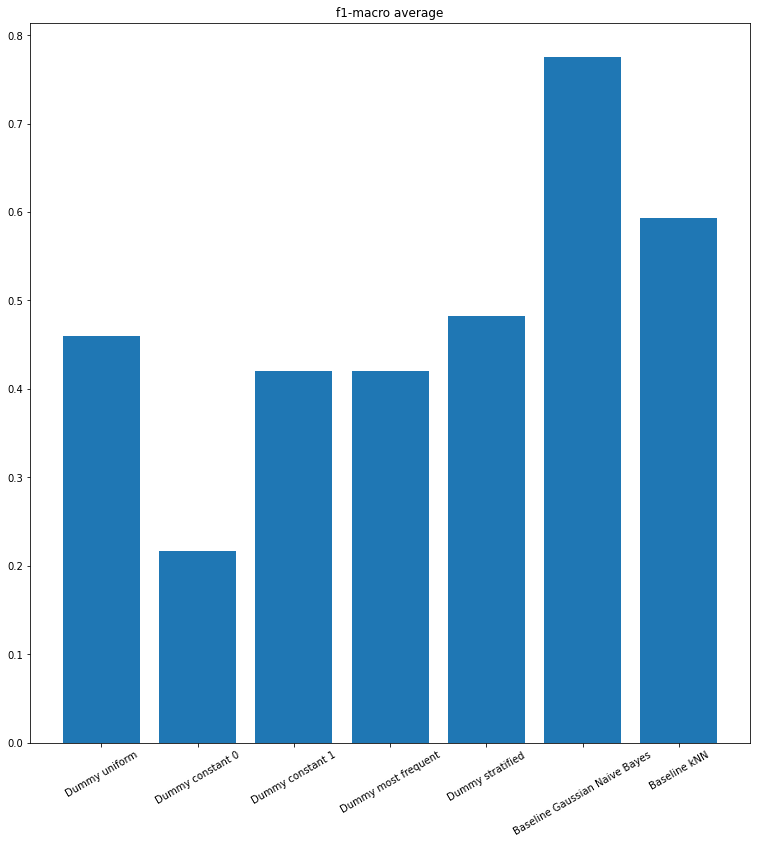

In [ ]:
bar_plot_predictions = {}

#Concatenate all predictions to print bar plots
for d in dc_predictions, gnb_base_predictions, knn_base_predictions:
  bar_plot_predictions.update(d)

print_bar_plots(bar_plot_predictions, test_labels, 'micro')
print_bar_plots(bar_plot_predictions, test_labels, 'macro')

Από τα παραπάνω διαγράμματα και τους πίνακες σύγχυσης, παρατηρούμε τα εξής:

*   Οι dummy classifiers είναι χειρότεροι και στις 2 κατηγορίες από τους "έξυπνους" ταξινομητές μας και ιδιαίτερα όσον αφορά στη μετρική f1-macro. Αυτό ήταν αναμενόμενο αφού απλώς ακολουθούν μια προκαθορισμένη στρατηγική και δεν μαθαίνουν από το dataset.
*   Ο ταξινομητής Gaussian Naive Bayes έχει αρκετά καλή επίδοση ακόμη και χωρίς preprocessing. Όμως έχει σχετικά χαμηλό recall στην κλάση 0. Στο dataset μας, το recall της κλάσης 0 έχει ιδιαίτερη σημασία εφόσον πρόκειται για το ποσοστό των μη υγιών δειγμάτων που εντοπίστηκαν.
* Ο baseline kNN είναι ακόμα χειρότερος σε αυτό τον τομέα, αφού έχει μόλις 0.26 recall για τα μη υγιή δείγματα. Στη βελτιστοποίηση βέβαια, θα δούμε ότι αυτό θα αυξηθεί δραματικά.



## Βελτιστοποίηση ταξινομητών

### Data Evaluation

Γνωρίζουμε ότι έχουμε 62 features. Επομένως αναμένουμε οτι θα χρειαστεί (και μάλλον θα είναι συμφέρον) να αφαιρέσουμε κάποια είτε μέσω κάποιου selector είτε μέσω PCA. Επίσης, βλέποντας το αρχείο δεδομένων παρατηρούμε ότι τα δεδομένα έχουν πολύ διαφορετικές τάξεις μεγέθους (κάποια παίρνουν τιμές κοντά στο $10^{-2}$ ενώ κάποια άλλα έχουν τάξη μεγέθους $10^5$). Άρα αναμένουμε ότι θα είναι απαραίτητο να κάνουμε scale τα δεδομένα, ειδικά για τον ταξινομητή kNN. Παρακάτω, μπορούμε να δούμε τα variances των χαρακτηριστικών ώστε να αποφασίσουμε το threshold του selector.

In [ ]:
selector = VarianceThreshold()
selector.fit(train)
print(selector.variances_)

[5.13782246e-02 3.34356891e-05 3.65815113e-02 2.83812341e-02
 4.81326538e-03 4.40888497e-03 3.05637004e-02 1.35202201e-02
 1.04824909e-02 1.05262133e-03 3.29208251e-03 5.80859296e-04
 1.37433519e-02 1.37715698e-03 1.93147521e-02 1.94878145e+02
 8.14999126e+01 1.80736213e+02 2.35227389e+02 2.27602760e+02
 8.10512069e+01 2.12325440e+02 2.73685233e+02 2.24980588e+02
 9.07989021e+01 2.14741022e+02 2.73329750e+02 1.36140842e+02
 8.18128438e+01 9.47738630e+01 1.96613655e+02 1.78878533e+02
 8.74079393e+01 1.39502178e+02 2.39513019e+02 1.97182097e+02
 9.33318937e+01 1.76134601e+02 2.47290405e+02 4.81119784e-01
 3.33265940e-01 2.44195620e+02 1.18877785e+02 2.27607412e+02
 8.68579785e+01 4.08463411e-01 5.98661484e-02 2.37944761e+02
 1.02797077e+02 1.96992472e+02 9.19424400e+01 3.24886959e-02
 5.00113962e-02 2.98883649e-02 5.46803928e-02 1.84010715e-02
 1.68127742e-01 3.43861259e-02 4.56284234e-02 4.98665052e+02
 5.42642169e-02 2.55941634e-02 2.25968231e-01 2.27303064e-01
 2.36608760e-01 1.869529

In [ ]:
#We will keep training and prediction times here
times = {}

### GNB Optimization

In [ ]:
#Optimizing GNB based on f1 micro average and f1 macro average
selector = VarianceThreshold()
scaler = StandardScaler()
pca = PCA()
clf = GaussianNB()

vthreshold = [0,0.1, 0.01, 0.001, 0.0001]
p = list(range(10,30))
parameters = {
    'selector__threshold' : vthreshold,
    'pca__n_components' : p
}

pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('pca', pca), ('gnb', clf)], memory = 'tmp')
gnb_micro = GridSearchCV(pipe, parameters, cv=10, scoring='f1_micro', verbose=10, n_jobs=-1)
gnb_macro = GridSearchCV(pipe, parameters, cv=10, scoring='f1_macro', verbose=10, n_jobs=-1)
gnb_micro.fit(train, train_labels)
gnb_macro.fit(train, train_labels)
print('best f1 micro parameters', gnb_micro.best_params_)
print('best f1 macro parameters', gnb_macro.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1830s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1135s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1991s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0318s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0666s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0820s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1622s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 892 t

best f1 micro parameters {'pca__n_components': 10, 'selector__threshold': 0.1}
best f1 macro parameters {'pca__n_components': 10, 'selector__threshold': 0.1}


[Parallel(n_jobs=-1)]: Done 995 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.1s finished



f1-micro average for f1 micro optimized GNB : 0.8620689655172413
f1-macro average for f1 micro optimized GNB : 0.8201550387596899
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.89      0.93      0.91        42

    accuracy                           0.86        58
   macro avg       0.84      0.81      0.82        58
weighted avg       0.86      0.86      0.86        58



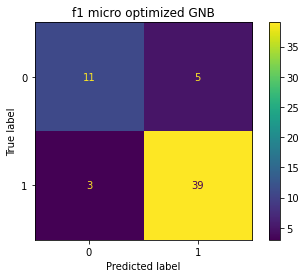

------------------------------------------------------------

f1-micro average for f1 macro optimized GNB : 0.8620689655172413
f1-macro average for f1 macro optimized GNB : 0.8201550387596899
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.89      0.93      0.91        42

    accuracy                           0.86        58
   macro avg       0.84      0.81      0.82        58
weighted avg       0.86      0.86      0.86        58



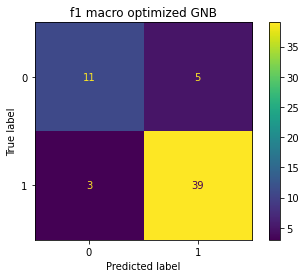

------------------------------------------------------------


In [ ]:
gnb_micro_preds, times['f1 micro optimized GNB'] = train_best_time_and_predict(gnb_micro, train, train_labels, test)
gnb_macro_preds, times['f1 macro optimized GNB'] = train_best_time_and_predict(gnb_macro, train, train_labels, test)

gnb_best_predictions = {
    'f1 micro optimized GNB' : gnb_micro_preds,
    'f1 macro optimized GNB' : gnb_macro_preds
}

plot_confusion_matrix_and_scores(gnb_best_predictions, test_labels)

Για το Optimization του GNB με βάση τις δυο μετρικές f1 micro και f1 macro γνωρίζουμε ότι μπορούμε να βελτιστοποιήσουμε μόνο τις υπερπαραμέτρους των συναρτήσεων preprocessing.

Εκτός από το παραπάνω pipeline, δοκιμάσαμε διάφορους συνδυασμούς preprocessing μεταξύ των γνωστών (VarianceThreshold, StandardScaler, PCA, με RandomOverSampler για εξισορρόπηση του dataset, αλλαγή StandardScaler με MinMaxScaler) αλλά ο βέλτιστος συνδυασμός αποδείχθηκε αυτός που βλέπουμε παραπάνω **και για τις 2 μετρικές**.

Για το παραπάνω pipeline τρέξαμε αρχικά ένα GridSearch με παραμέτρους:

```
vthreshold = [0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
pca = [10, 20, 30, 40, 50, 60]
```

και είδαμε από τα αναλυτικά αποτελέσματα ότι η υπερπαράμετρος n_components του pca φέρνει βέλτιστα αποτελέσματα στο διάστημα (10, 30). Επομένως, τρέχουμε τελικά το GridSearch που βλέπουμε παραπάνω για να λάβουμε τα βέλτιστα αποτελέσματα.


Βλέπουμε ότι όντως υπάρχει βελτίωση της απόδοσης σε σχέση με τον baseline GNB και για τις 2 μετρικές, ενώ βλέπουμε και ότι το GridSearch ανέδειξε τις ίδιες τιμές υπερπαραμέτρων. Αυτό δε θα γίνεται πάντα όπως θα δούμε και παρακάτω. Ο σχολιασμός των πινάκων σύγχυσης γίνεται παρακάτω, στο section *Συνολικά αποτελέσματα και σχολιασμός*

### kNN Optimization

In [ ]:
selector = VarianceThreshold()
scaler = StandardScaler()
clf = KNeighborsClassifier(n_jobs=-1)

vthreshold = [0,0.1, 0.01]
p = list(range(10,30, 2))
k = list(range(1,30,2)) # η υπερπαράμετρος του ταξινομητή


pipe_micro = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('pca', pca), ('kNN', clf)], memory = 'tmp')
knn_micro = GridSearchCV(pipe_micro, dict(selector__threshold=vthreshold, pca__n_components=p, kNN__n_neighbors=k), cv=10, scoring='f1_micro', verbose=10, n_jobs=-1)
knn_micro.fit(train, train_labels)
print(knn_micro.best_params_)

Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1255s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 244 tas

{'kNN__n_neighbors': 1, 'pca__n_components': 14, 'selector__threshold': 0.1}


[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  4.4min finished


In [ ]:
knn_micro_preds, times['f1 micro optimized kNN'] = train_best_time_and_predict(knn_micro, train, train_labels, test)

knn_best_predictions = {
    'f1 micro optimized kNN' : knn_micro_preds
}

In [ ]:
selector = VarianceThreshold()
scaler = StandardScaler()
#pca = PCA()
ros = RandomOverSampler()
clf = KNeighborsClassifier(n_jobs=-1)

vthreshold = [0,0.1, 0.01]
#p = list(range(10,30,2))
k = list(range(1,30,2)) # η υπερπαράμετρος του ταξινομητή

pipe_macro = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('kNN', clf)], memory = 'tmp')
knn_macro = GridSearchCV(pipe_macro, dict(selector__threshold=vthreshold, kNN__n_neighbors=k), cv=10, scoring='f1_macro', verbose=10, n_jobs=-1)
knn_macro.fit(train, train_labels)
print(knn_macro.best_params_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

{'kNN__n_neighbors': 5, 'selector__threshold': 0.1}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   27.6s finished



f1-micro average for f1 micro optimized kNN : 0.8620689655172413
f1-macro average for f1 micro optimized kNN : 0.8201550387596899
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.89      0.93      0.91        42

    accuracy                           0.86        58
   macro avg       0.84      0.81      0.82        58
weighted avg       0.86      0.86      0.86        58



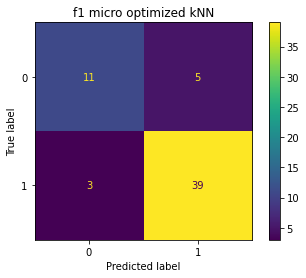

------------------------------------------------------------

f1-micro average for f1 macro optimized kNN : 0.896551724137931
f1-macro average for f1 macro optimized kNN : 0.8791666666666667
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.97      0.88      0.93        42

    accuracy                           0.90        58
   macro avg       0.86      0.91      0.88        58
weighted avg       0.91      0.90      0.90        58



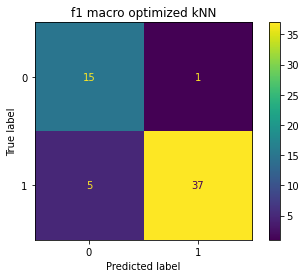

------------------------------------------------------------


In [ ]:
knn_macro_preds, times['f1 macro optimized kNN'] = train_best_time_and_predict(knn_macro, train, train_labels, test)

knn_best_predictions['f1 macro optimized kNN'] = knn_macro_preds

plot_confusion_matrix_and_scores(knn_best_predictions, test_labels)

Για τη βελτιστοποίηση του kNN micro είχε δοκιμαστεί και ο RandomOverSampler βγάζοντας χειρότερα αποτελέσματα από ότι το επιλεγμένο pipeline χωρίς.  
Παρόλα αυτά βλέπουμε ότι ο f1 macro optimized kNN έχει καλύτερα αποτελέσματα και στη μετρική f1 micro. Αυτό συμβαίνει διότι το dataset μας είναι μικρό, και η τυχαιότητα του RandomOverSampler επηρεάζει τα τελικά αποτελέσματα παραπάνω από ότι σε ένα μεγάλο dataset.

Όσον αφορά στα GridSearch, για τη βελτιστοποίηση της μετρικής f1 micro ξεκινήσαμε με τις παραμέτρους:

```
vthreshold = [0, 0.1, 0.01, 0.001, 0.0001]
k = [10,20,30,40,50]
p = [10,20,30,40,50,60]
```

Κοιτώντας τα αναλυτικά αποτελέσματα (όπου οι καλύτεροι συνδυασμοί είχαν k=[10,20], p = [20,30] και vthreshold = [0.1, 0.01]) αποφασίσαμε να τρέξουμε ένα 2ο GridSearch με τις παραμέτρους που φαίνονται παραπάνω, λαμβάνοντας πολύ καλά τελικά αποτελέσματα σε σχέση με τον baseline ταξινομητή kNN.

Για τη μετρική f1 micro είδαμε ότι το pca έριχνε την απόδοση επομένως το αφήσαμε εκτός pipeline. Ξεκινήσαμε το 1ο GridSearch με τις παραμέτρους: 

```
vthreshold = [0, 0.1, 0.01, 0.001, 0.0001]
k = [10,20,30,40,50]
```

Τα αποτελέσματα ήταν παρόμοια με αυτά που περιγράψαμε για τη βελτιστοποίηση της μετρικής f1 micro και επομένως ακολουθήσαμε παρόμοια στρατηγική παίρνοντας 2η GridSearch με τις παραμέτρους που φαίνονται στο κελί.

### Συνολικά αποτελέσματα και σχολιασμός

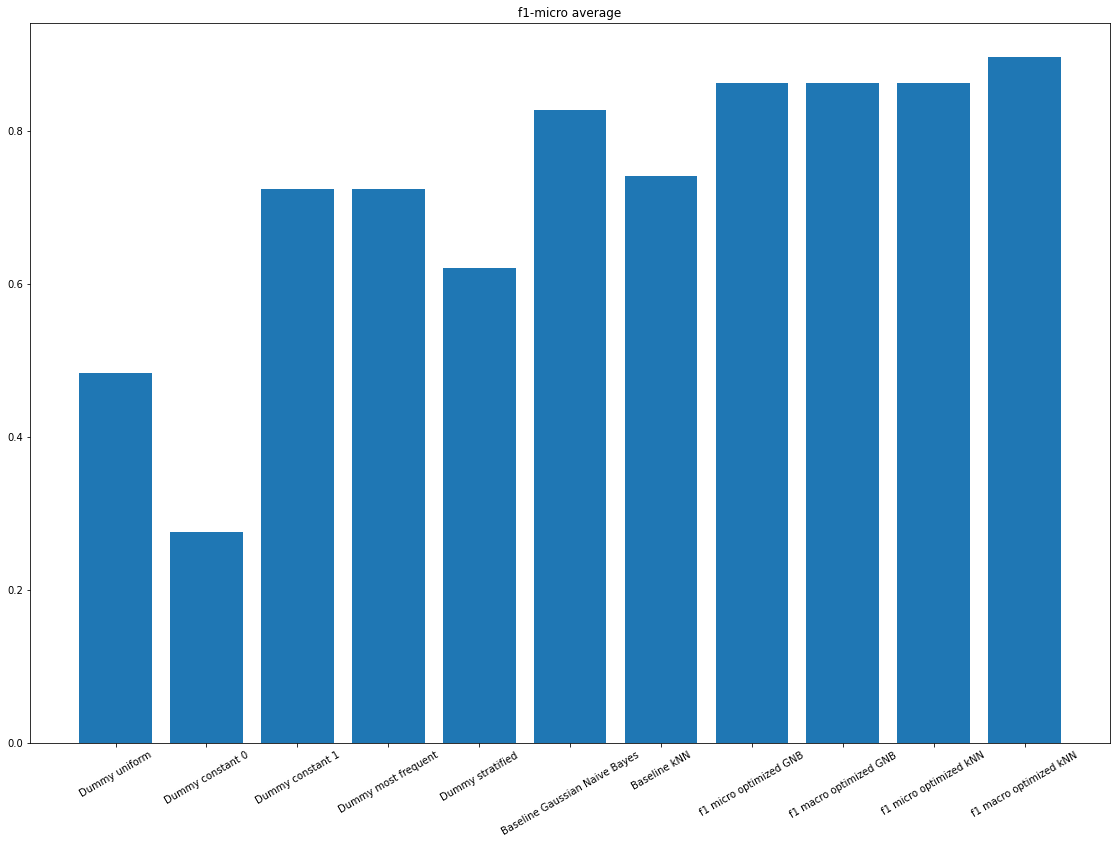

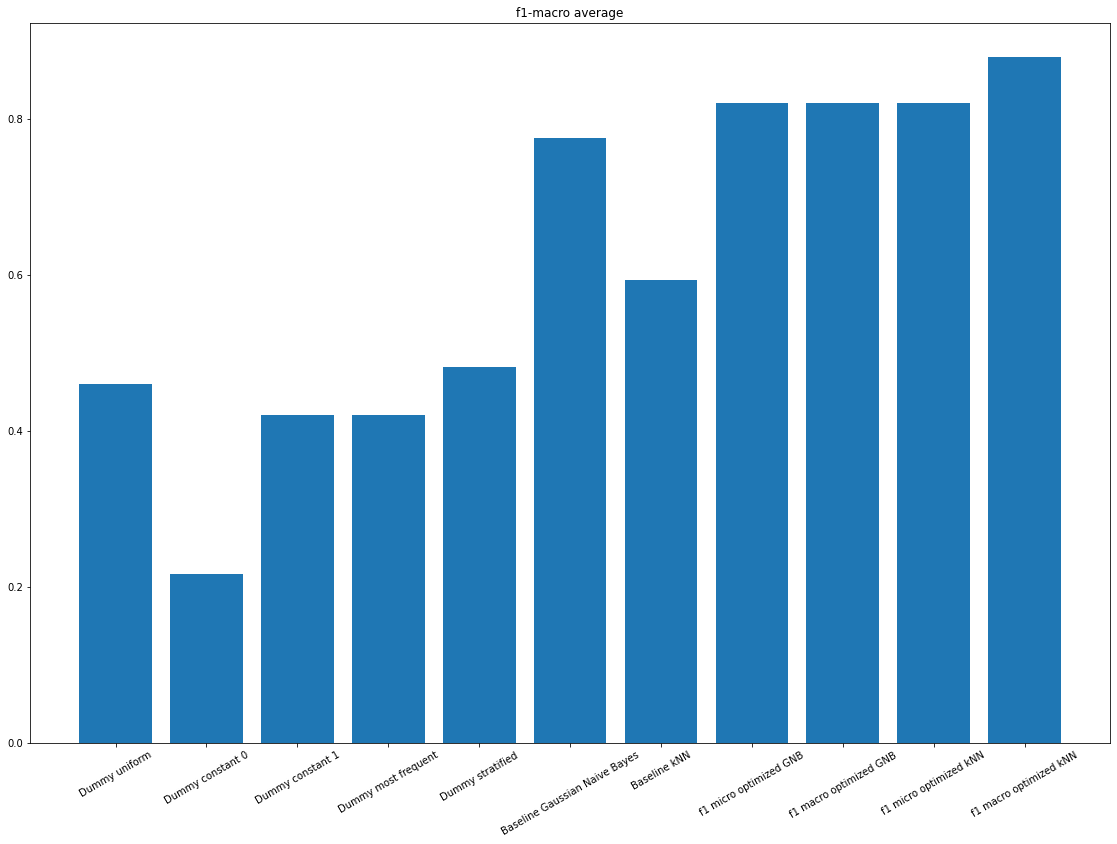

In [ ]:
#Update bar plot
for d in gnb_best_predictions, knn_best_predictions:
  bar_plot_predictions.update(d)

print_bar_plots(bar_plot_predictions, test_labels, 'micro', size=(15,10))
print_bar_plots(bar_plot_predictions, test_labels, 'macro', size=(15,10))

Βλέπουμε ότι οι ταξινομητές μας βελτιώθηκαν αρκετά σε σχέση με τους baseline και για τις 2 μετρικές. Ιδιαίτερα ο f1 macro optimized kNN αγγίζει 90% ακρίβεια στο dataset, ενώ πολύ σημαντικό είναι ότι έκανε μόλις 1 misclassification δείγματος με true label 0 (**μη υγιής κολποσκόπηση**).

Για τους dummy δεν είχε ιδιαίτερη αξία να εξετάσουμε τις επιπτώσεις του preprocessing, αφού εφόσον γίνεται μετα το train_test_split μπορεί να αλλάξει μόνο τα αποτελέσματα του dummy stratified, τα οποία προφανώς δε θα έφταναν ποτέ τα νούμερα που πέτυχαν οι ταξινομητές GNB και kNN.

In [ ]:
#Plot times
pd.DataFrame.from_dict(times, orient='index', columns=['times'])

,times
f1 micro optimized GNB,0.012816
f1 macro optimized GNB,0.006733
f1 micro optimized kNN,0.121846
f1 macro optimized kNN,0.119448


Για τους χρόνους δεν υπάρχει κάτι άξιο σχολιασμου αφού έχουμε ένα πολύ μικρό dataset και οι χρόνοι είναι κάτω του δευτερολέπτου. Βλέπουμε όμως ότι ο f1 macro optimized GNB χρειάστηκε το μισό χρόνο εκπαίδευσης από ότι ο f1 micro optimized GNB παρότι εκπαιδεύτηκαν πάνω στο ίδιο train set (με ίδια υπερπαράμετρο PCA n_components). Αυτό ίσως οφείλεται σε κάποιο caching που μπορεί να κάνει το Google Colab, ή σε καλύτερη παραλληλοποίηση που μπορεί να έγινε κατά την εκπαίδευση. 

In [ ]:
#Plot performance differences
performance_dict = {
    'GNB': [gnb_base_preds, gnb_micro_preds, gnb_macro_preds],
    'kNN': [knn_base_preds, knn_micro_preds, knn_macro_preds]
}

In [ ]:
#We want to change the dictionary values, so we copy the original to make sure it's not lost
performance_micro = copy.deepcopy(performance_dict)
change_preds_to_scores(performance_micro, test_labels, 'micro')
print("f1 micro scores before and after:")
pd.DataFrame.from_dict(performance_micro, orient='index', columns=['Baseline', 'f1 micro optimized', 'f1 macro optimized'])

f1 micro scores before and after:


,Baseline,f1 micro optimized,f1 macro optimized
GNB,0.827586,0.862069,0.862069
kNN,0.741379,0.862069,0.896552


In [ ]:
#We want to change the dictionary values, so we copy the original to make sure it's not lost
performance_macro = copy.deepcopy(performance_dict)
change_preds_to_scores(performance_macro, test_labels, 'macro')
print("f1 macro scores before and after:")
pd.DataFrame.from_dict(performance_macro, orient='index', columns=['Baseline', 'f1 micro optimized', 'f1 macro optimized'])

f1 macro scores before and after:


,Baseline,f1 micro optimized,f1 macro optimized
GNB,0.775194,0.820155,0.820155
kNN,0.593268,0.820155,0.879167


Στα 2 παραπάνω κελιά βλέπουμε τη βελτίωση στην απόδοση των ταξινομητών μετά την προεπεξεργασία των δεδομένων τη βελτιστοποίηση των υπερπαραμέτρων τους. Είναι αξιοσημείωτο ότι για τον kNN έχουμε αύξηση απο 0.6 σε 0.82 και 0.88 αντίστοιχα στη μετρική f1 macro. Γενικά βλέπουμε ότι υπάρχει μεγάλη βελτίωση και στους 2 ταξινομητές και για τις 2 μετρικές.

#Μέρος 2ο (big dataset)

## Βασικές πληροφορίες
1. Το μεγάλο dataset περιλαμβάνει δεδομένα από 19.020 τεχνητές "παρατηρήσεις" ακτινών γάμμα από τηλεσκόπιο Cherenkov. Τα δεδομένα έχουν παραχθεί από σημειώσεις Monte Carlo (δεν προέρχονται από πραγματικές μετρήσεις) και περιλαμβάνουν ανάλυση μοτίβων φωτονίων (δεκάδες έως δεκάδες χιλιάδες) αναλόγως την ενέργεια της ακτίνας. Ανάλογα με τα μοτίβα που παρατηρούνται διαχωρίζουμε τα φωτόνια που παράγονται από την πρωτεύουσα ακτίνα γάμμα (signal) από τις εικόνες αδρονικών καταιγισμών που παράγονται από κοσμικές ακτίνες (background)

2. Αριθμός δειγμάτων: 19020  
Αριθμός χαρακτηριστικών: 11 εκ των οποίων τo 1 είναι target.  

3. Δεν υπάρχουν επικεφαλίδες ούτε αρίθμηση γραμμών.

4. Οι ετικέτες των κλάσεων είναι g και h και βρίσκονται στην κολόνα 10 (με αρίθμηση από το 0).

5. Δεν χρειάστηκε να κάνουμε κάποια μετατροπή στο αρχείο δεδομένων

6. Δεν υπάρχουν απουσιάζουσες τιμές.

7. Υπάρχουν 2 κλάσεις, η κλάση **g** (signal) και η κλάση **h** (background). Το ποσοστό των 2 κλάσεων είναι 65-35 με την πλειονότητα των δειγμάτων να κατατάσσονται στην κλάση **g**. Επομένως το dataset είναι μη ισορροπημένο. Το φαινόμενο αυτό αντιμετωπίστηκε διαφορετικά για κάθε ταξινομητή και αναλύονται οι επιλογές μας ξεχωριστά παρακάτω.

8. Ο διαχωρισμός σε train,test φαίνεται παρακάτω

In [ ]:
#Import dataset and separate labels from features
df = pd.read_csv("magic04.csv", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [ ]:
labels_df = df.iloc[:, -1]
labels = labels_df.values

features_df = df.iloc[:, :-1]
features = features_df.values

#Dataset is imbalanced (65%-35%). Majority class: g
check_balance(labels)

#Split data
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.3)

g: 12332 - 65%
h: 6688 - 35%


In [ ]:
#Display labels for our confusion matrices
disp_labels = ['g','h']

## Baseline Classification

### Dummy Classifiers


f1-micro average for Dummy uniform : 0.49859796705222575
f1-macro average for Dummy uniform : 0.48524530666782284
Classification report:
              precision    recall  f1-score   support

           g       0.66      0.50      0.57      3768
           h       0.34      0.50      0.40      1938

    accuracy                           0.50      5706
   macro avg       0.50      0.50      0.49      5706
weighted avg       0.55      0.50      0.51      5706



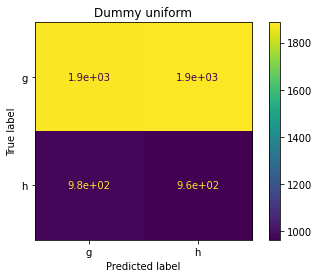

------------------------------------------------------------

f1-micro average for Dummy constant h : 0.33964248159831756
f1-macro average for Dummy constant h : 0.25353218210361067
Classification report:
              precision    recall  f1-score   support

           g       0.00      0.00      0.00      3768
           h       0.34      1.00      0.51      1938

    accuracy                           0.34      5706
   macro avg       0.17      0.50      0.25      5706
weighted avg       0.12      0.34      0.17      5706



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


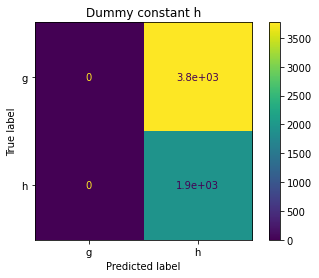

------------------------------------------------------------

f1-micro average for Dummy constant g : 0.6603575184016824
f1-macro average for Dummy constant g : 0.3977200759974668
Classification report:
              precision    recall  f1-score   support

           g       0.66      1.00      0.80      3768
           h       0.00      0.00      0.00      1938

    accuracy                           0.66      5706
   macro avg       0.33      0.50      0.40      5706
weighted avg       0.44      0.66      0.53      5706



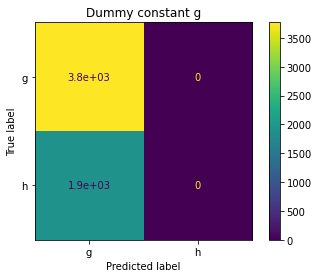

------------------------------------------------------------

f1-micro average for Dummy most frequent : 0.6603575184016824
f1-macro average for Dummy most frequent : 0.3977200759974668
Classification report:
              precision    recall  f1-score   support

           g       0.66      1.00      0.80      3768
           h       0.00      0.00      0.00      1938

    accuracy                           0.66      5706
   macro avg       0.33      0.50      0.40      5706
weighted avg       0.44      0.66      0.53      5706



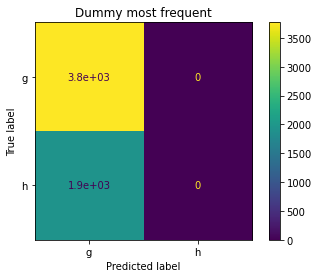

------------------------------------------------------------

f1-micro average for Dummy stratified : 0.5620399579390115
f1-macro average for Dummy stratified : 0.5163952009241718
Classification report:
              precision    recall  f1-score   support

           g       0.67      0.66      0.66      3768
           h       0.36      0.38      0.37      1938

    accuracy                           0.56      5706
   macro avg       0.52      0.52      0.52      5706
weighted avg       0.57      0.56      0.56      5706



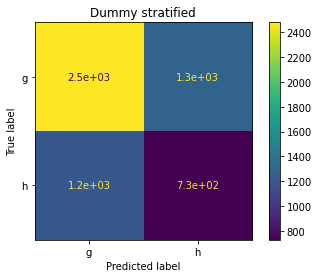

------------------------------------------------------------


In [ ]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_h = DummyClassifier(strategy="constant", constant='h')
dc_constant_g = DummyClassifier(strategy="constant", constant='g')
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

dc_uniform.fit(train, train_labels)
dc_constant_h.fit(train, train_labels)
dc_constant_g.fit(train, train_labels)
dc_most_frequent.fit(train, train_labels)
dc_stratified.fit(train, train_labels)

dc_uniform_preds = dc_uniform.predict(test)
dc_constant_h_preds = dc_constant_h.predict(test)
dc_constant_g_preds = dc_constant_g.predict(test)
dc_most_frequent_preds = dc_most_frequent.predict(test)
dc_stratified_preds = dc_stratified.predict(test)


dc_predictions = {
    'Dummy uniform': dc_uniform_preds, 
    'Dummy constant h': dc_constant_h_preds, 
    'Dummy constant g': dc_constant_g_preds, 
    'Dummy most frequent' : dc_most_frequent_preds, 
    'Dummy stratified' : dc_stratified_preds
}

plot_confusion_matrix_and_scores(dc_predictions,test_labels,disp_labels)

### Baseline Gaussian Naive Bayes


f1-micro average for Baseline Gaussian Naive Bayes : 0.7288818787241499
f1-macro average for Baseline Gaussian Naive Bayes : 0.6530952154418217
Classification report:
              precision    recall  f1-score   support

           g       0.74      0.91      0.82      3768
           h       0.68      0.38      0.49      1938

    accuracy                           0.73      5706
   macro avg       0.71      0.65      0.65      5706
weighted avg       0.72      0.73      0.71      5706



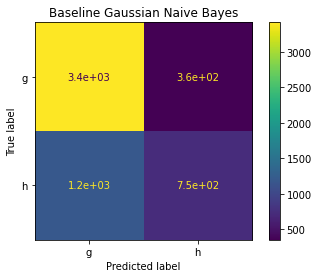

------------------------------------------------------------


In [ ]:
gnb_base = GaussianNB()
gnb_base.fit(train, train_labels)
gnb_base_preds = gnb_base.predict(test)

gnb_base_predictions = {
    'Baseline Gaussian Naive Bayes' : gnb_base_preds
}

plot_confusion_matrix_and_scores(gnb_base_predictions,test_labels, disp_labels)

### Baseline kNN


f1-micro average for Baseline kNN : 0.8119523308797757
f1-macro average for Baseline kNN : 0.7749767379397009
Classification report:
              precision    recall  f1-score   support

           g       0.82      0.92      0.87      3768
           h       0.80      0.60      0.68      1938

    accuracy                           0.81      5706
   macro avg       0.81      0.76      0.77      5706
weighted avg       0.81      0.81      0.80      5706



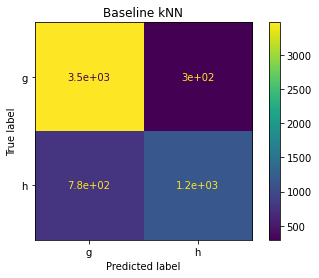

------------------------------------------------------------


In [ ]:
knn_base = KNeighborsClassifier()
knn_base.fit(train, train_labels)
knn_base_preds = knn_base.predict(test)

knn_base_predictions = {
    'Baseline kNN' : knn_base_preds
}
plot_confusion_matrix_and_scores(knn_base_predictions,test_labels, disp_labels)

### Baseline MLP


f1-micro average for Baseline MLP : 0.8347353662811076
f1-macro average for Baseline MLP : 0.8116668679820571
Classification report:
              precision    recall  f1-score   support

           g       0.86      0.90      0.88      3768
           h       0.78      0.71      0.75      1938

    accuracy                           0.83      5706
   macro avg       0.82      0.81      0.81      5706
weighted avg       0.83      0.83      0.83      5706



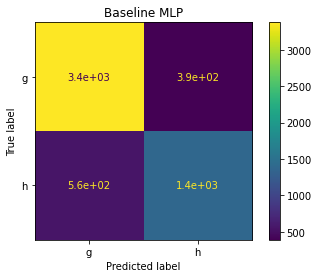

------------------------------------------------------------


In [ ]:
mlp_base = MLPClassifier()
mlp_base.fit(train, train_labels)
mlp_base_preds = mlp_base.predict(test)

mlp_base_predictions = {
    'Baseline MLP' : mlp_base_preds
}
plot_confusion_matrix_and_scores(mlp_base_predictions, test_labels,disp_labels)

### Baseline SVM's

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



f1-micro average for Baseline linear SVC : 0.5559060637924991
f1-macro average for Baseline linear SVC : 0.555119012938621
Classification report:
              precision    recall  f1-score   support

           g       0.86      0.39      0.54      3768
           h       0.43      0.88      0.57      1938

    accuracy                           0.56      5706
   macro avg       0.64      0.63      0.56      5706
weighted avg       0.71      0.56      0.55      5706



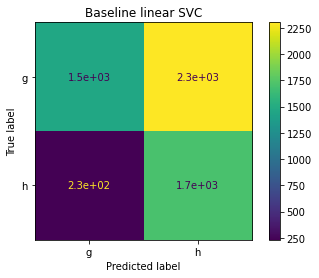

------------------------------------------------------------

f1-micro average for Baseline poly SVC : 0.8175604626708728
f1-macro average for Baseline poly SVC : 0.7733104173778608
Classification report:
              precision    recall  f1-score   support

           g       0.81      0.95      0.87      3768
           h       0.86      0.55      0.67      1938

    accuracy                           0.82      5706
   macro avg       0.83      0.75      0.77      5706
weighted avg       0.82      0.82      0.81      5706



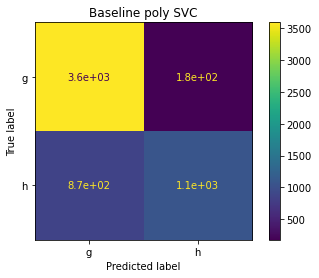

------------------------------------------------------------

f1-micro average for Baseline rbf SVC : 0.8222923238696109
f1-macro average for Baseline rbf SVC : 0.7819635880182332
Classification report:
              precision    recall  f1-score   support

           g       0.81      0.95      0.88      3768
           h       0.85      0.58      0.69      1938

    accuracy                           0.82      5706
   macro avg       0.83      0.76      0.78      5706
weighted avg       0.83      0.82      0.81      5706



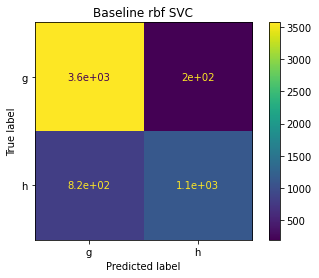

------------------------------------------------------------


In [ ]:
svc_linear_base = LinearSVC()
svc_poly_base = SVC(kernel='poly')
svc_rbf_base = SVC()

svc_linear_base.fit(train, train_labels)
svc_poly_base.fit(train, train_labels)
svc_rbf_base.fit(train, train_labels)

svc_linear_base_preds = svc_linear_base.predict(test)
svc_poly_base_preds = svc_poly_base.predict(test)
svc_rbf_base_preds = svc_rbf_base.predict(test)

svc_base_predictions = {
    'Baseline linear SVC' : svc_linear_base_preds,
    'Baseline poly SVC' : svc_poly_base_preds,
    'Baseline rbf SVC' : svc_rbf_base_preds
}

plot_confusion_matrix_and_scores(svc_base_predictions, test_labels, disp_labels)

### Αποτελέσματα και σχολιασμός Baseline ταξινόμησης

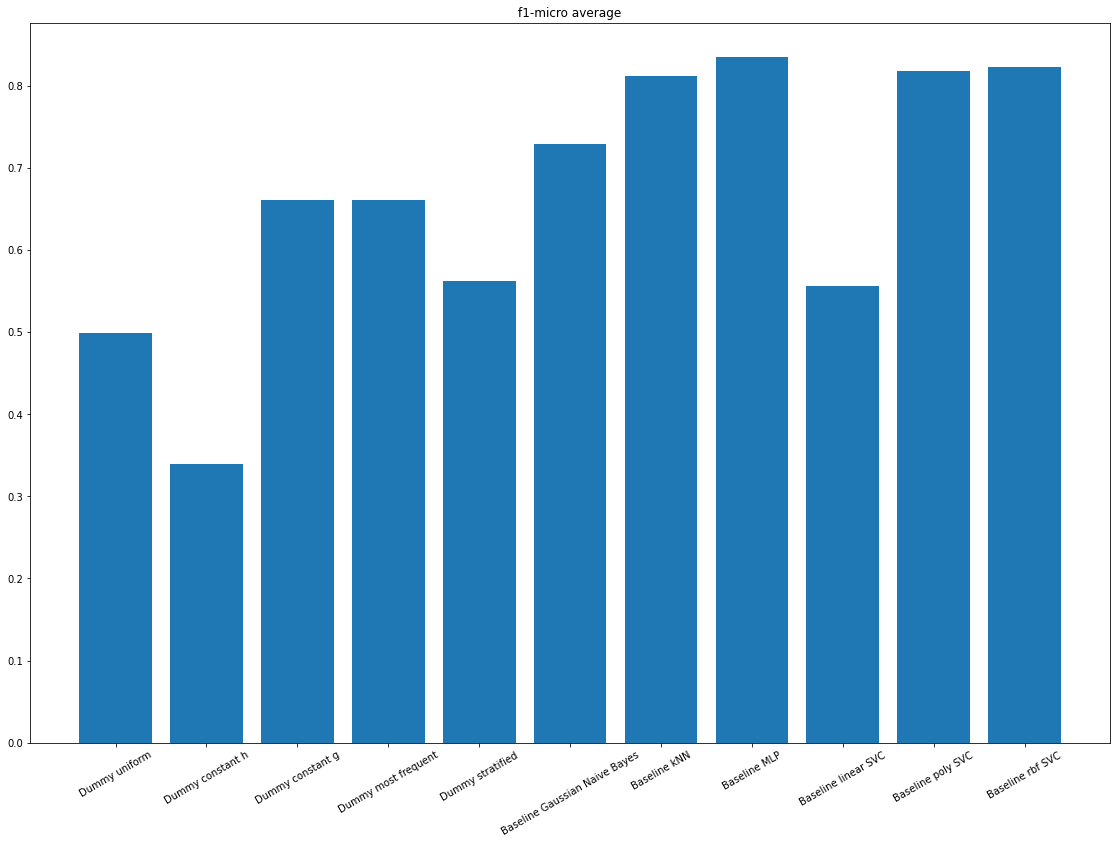

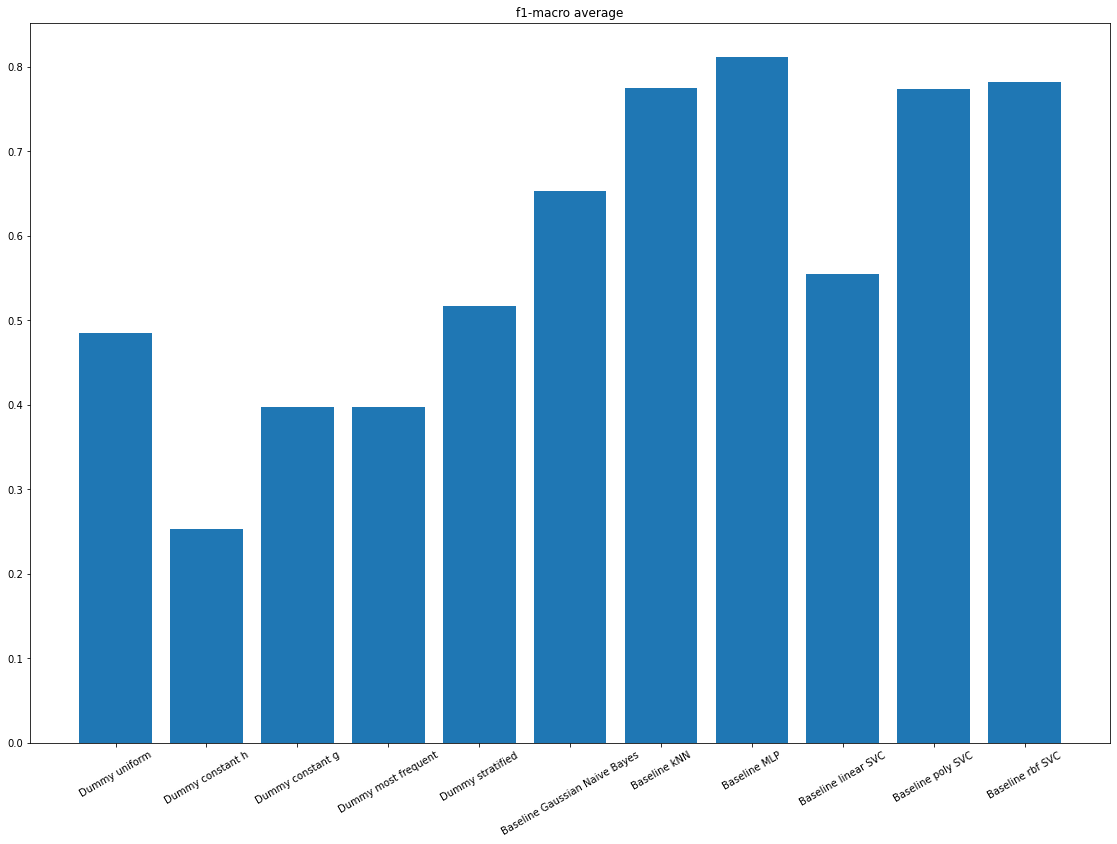

In [ ]:
bar_plot_predictions = {}

#Concatenate all predictions to print bar plots
for d in dc_predictions, gnb_base_predictions, knn_base_predictions, mlp_base_predictions, svc_base_predictions:
  bar_plot_predictions.update(d)

print_bar_plots(bar_plot_predictions, test_labels, 'micro', size=(15,10))
print_bar_plots(bar_plot_predictions, test_labels, 'macro', size=(15,10))

Από τα παραπάνω διαγράμματα άξια σχολιασμού είναι τα εξής:


*   Όπως και στο μικρό dataset, έτσι και στο μεγάλο οι έξυπνοι ταξινομητές έχουν καλύτερη επίδοση από τους dummy ακόμα και χωρίς preprocessing ή βελτιστοποίηση. Εξαίρεση αποτελεί ο LinearSVC ο οποίος έχει πολύ κακή επίδοση με απλή αρχικοποίηση
*   Όπως και στο προηγούμενο dataset, πάλι έχει νόημα να σκεφτούμε τα misclassifications. Μαθαίνουμε από το UCI Repository ότι το misclassification ενός φαινομένου h ως φαινόμενο g είναι πολύ χειρότερο από το misclassification ενός φαινομένου g ως φαινόμενο h. Επομένως αξίζει να σχολιάζουμε το recall της κλάσης h.
* Βλέποντας τα recall της κλάσης h για κάθε ταξινομητή, παρατηρούμε ότι όλοι εκτός από τον ταξινομητή MLP έχουν αρκετά χαμηλότερη τιμή σε σχέση με τις τιμές των μετρικών που βλέπουμε στα plots. Κατα τη βελτιστοποίηση, αντιμετωπίζουμε αυτό το φαινόμενο εξισορροπώντας το dataset.



## Βελτιστοποίηση ταξινομητών

### Data Evaluation

Γνωρίζουμε ότι έχουμε 10 features. Βλέποντας τις τιμές τους, παρατηρούμε ότι πολλά έχουν διαφορετικές τάξεις μεγέθους οπότε είναι ασφαλές να υποθέσουμε ότι θα χρειαστούν scaling.

Πράγματι, στις δοκιμές των διάφορων pipelines που κάναμε για τους διάφορους ταξινομητές, το scaled dataset έδινε καλύτερες τιμές. Επίσης, η όποια προσπάθειά μας να αφαιρέσουμε low variance features ή να κάνουμε PCA έφερε χειρότερα αποτελέσματα, που σημαίνει ότι όλα τα features είναι χρήσιμα. Όμως, θα δούμε ότι σε πολλούς ταξινομητές το PCA με όλα τα features (δηλαδή αλλαγή βάσης) αύξησε τα scores.

Μια άλλη παρατήρηση που μπορέσαμε να κάνουμε για πολλούς classifiers, ήταν ότι έδιναν καλύτερες τιμές f1-micro όταν διατηρούσαμε το train set εκτός ισορροπίας και καλύτερες τιμές f1-macro όταν το εξισορροπούσαμε.

Έτσι, όπως θα δούμε παρακάτω, το βέλτιστο pipeline για κάθε f1 micro optimization των classifiers ήταν scaling και pca με όλα τα χαρακτηριστικά, ενώ για f1 macro optimization προσθέτουμε και κάποιο τρόπο να εξισορροπηθεί το dataset (RandomUnderSampler για τους ταξινομητές που δεν μπορούν να το εξισορροπήσουν μόνοι τους, ενώ για τα SVM χρησιμοποιήσαμε την παράμετρο class_weight που έδωσε καλύτερα αποτελέσματα).

Παρακάτω φαίνονται τα variances των χαρακτηριστικών όπου βλέπουμε ότι όντως δεν υπάρχει feature με τόσο μικρό variance που θα το καθιστούσε αμελητέο.

In [ ]:
selector = VarianceThreshold()
selector.fit(train)
print(selector.variances_)

[3.29893500e+02 2.56382000e+02 2.22676153e-01 3.38183278e-02
 1.23430964e-02 1.02519330e+03 5.70101000e+02 3.85745700e+02
 9.00000000e+01 4.65125200e+02]


Επίσης, κάνουμε sample 1000 δείγματα ώστε να μπορούμε να τρέξουμε κάποια "φθηνότερα" GridSearch

In [ ]:
idx = np.random.choice(np.arange(len(train)), 1000, replace=False)
train_small = train[idx]
train_labels_small = train_labels[idx]

### GNB Optimization

In [ ]:
#Optimizing GNB based on f1 micro average and f1 macro average
scaler = StandardScaler()
pca = PCA()
rus = RandomUnderSampler()
clf = GaussianNB()

p = list(range(11))
parameters = {
    'pca__n_components' : p
}

pipe_micro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('gnb', clf)], memory = 'tmp')
pipe_macro = Pipeline(steps=[('scaler', scaler), ('rus', rus), ('pca', pca), ('gnb', clf)], memory = 'tmp')
gnb_micro = GridSearchCV(pipe_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
gnb_macro = GridSearchCV(pipe_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
gnb_micro.fit(train, train_labels)
gnb_macro.fit(train, train_labels)
print('best f1 micro parameters', gnb_micro.best_params_)
print('best f1 macro parameters', gnb_macro.best_params_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   10.4s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    9.8s finished


best f1 micro parameters {'pca__n_components': 10}
best f1 macro parameters {'pca__n_components': 10}



f1-micro average for f1 micro optimized GNB : 0.755695758850333
f1-macro average for f1 micro optimized GNB : 0.7027588818104892
Classification report:
              precision    recall  f1-score   support

           g       0.77      0.89      0.83      3768
           h       0.70      0.49      0.58      1938

    accuracy                           0.76      5706
   macro avg       0.74      0.69      0.70      5706
weighted avg       0.75      0.76      0.74      5706



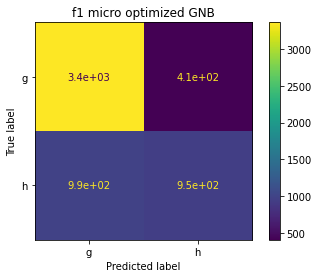

------------------------------------------------------------

f1-micro average for f1 macro optimized GNB : 0.7488608482299334
f1-macro average for f1 macro optimized GNB : 0.7072603161254255
Classification report:
              precision    recall  f1-score   support

           g       0.79      0.85      0.82      3768
           h       0.66      0.55      0.60      1938

    accuracy                           0.75      5706
   macro avg       0.72      0.70      0.71      5706
weighted avg       0.74      0.75      0.74      5706



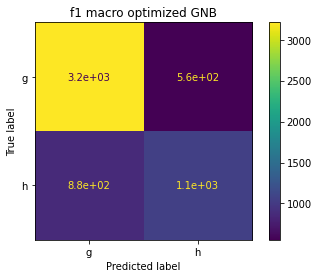

------------------------------------------------------------


In [ ]:
gnb_micro_preds, times['f1 micro optimized GNB'] = train_best_time_and_predict(gnb_micro, train, train_labels, test)
gnb_macro_preds, times['f1 macro optimized GNB'] = train_best_time_and_predict(gnb_macro, train, train_labels, test)

gnb_best_predictions = {
    'f1 micro optimized GNB' : gnb_micro_preds,
    'f1 macro optimized GNB' : gnb_macro_preds
}

plot_confusion_matrix_and_scores(gnb_best_predictions, test_labels, disp_labels)

Εφόσον ο GNB δεν έχει υπερπαραμέτρους προς βελτιστοποίηση και έχουμε δει ότι η αφαίρεση χαρακτηριστικών οδηγεί σε χειρότερη επίδοση, δεν είχαμε πολλές επιλογές για τη βελτιστοποίηση του GNB. Επιβεβαιώνουμε όμως με το GridSearch ότι η επίδοση με PCA βελτιστοποιείται όταν περιλαμβάνουμε όλα τα χαρακτηριστικά.

### kNN Optimization

In [ ]:
selector = VarianceThreshold()
scaler = StandardScaler()
pca = PCA()
clf = KNeighborsClassifier(n_jobs=-1)


k = list(range(1, 22, 2)) # η υπερπαράμετρος του ταξινομητή
weights = ['uniform', 'distance']
metric = ['euclidean', 'chebyshev', 'manhattan']

parameters = {
    'kNN__n_neighbors' : k,
    'kNN__weights' : weights,
    'kNN__metric' : metric
}

pipe_micro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('kNN', clf)], memory = 'tmp')
knn_micro = GridSearchCV(pipe_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
knn_micro.fit(train, train_labels)
print(knn_micro.best_params_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

{'kNN__metric': 'euclidean', 'kNN__n_neighbors': 11, 'kNN__weights': 'distance'}


In [ ]:
knn_micro_preds, times['f1 micro optimized kNN'] = train_best_time_and_predict(knn_micro, train, train_labels, test)

knn_best_predictions = {
    'f1 micro optimized kNN' : knn_micro_preds
}

In [ ]:
scaler = StandardScaler()
pca = PCA()
clf = KNeighborsClassifier(n_jobs=-1)
rus = RandomUnderSampler()

k = list(range(1,32,2))# η υπερπαράμετρος του ταξινομητή
weights = ['uniform', 'distance']
metric = ['euclidean', 'chebyshev', 'manhattan']

parameters = {
    'kNN__n_neighbors' : k,
    'kNN__weights' : weights,
    'kNN__metric' : metric
}

pipe_macro = Pipeline(steps=[('scaler', scaler), ('sampler', rus), ('pca', pca), ('kNN', clf)], memory = 'tmp')
knn_macro = GridSearchCV(pipe_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
knn_macro.fit(train, train_labels)
print(knn_macro.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

{'kNN__metric': 'manhattan', 'kNN__n_neighbors': 15, 'kNN__weights': 'distance'}



f1-micro average for f1 micro optimized kNN : 0.8468279004556607
f1-macro average for f1 micro optimized kNN : 0.8166786747753259
Classification report:
              precision    recall  f1-score   support

           g       0.84      0.95      0.89      3768
           h       0.87      0.65      0.74      1938

    accuracy                           0.85      5706
   macro avg       0.85      0.80      0.82      5706
weighted avg       0.85      0.85      0.84      5706



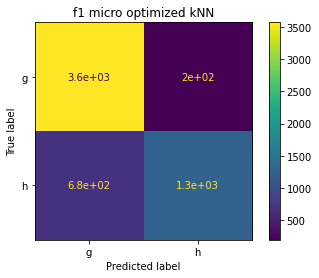

------------------------------------------------------------

f1-micro average for f1 macro optimized kNN : 0.8413950227830355
f1-macro average for f1 macro optimized kNN : 0.8197575301029774
Classification report:
              precision    recall  f1-score   support

           g       0.87      0.90      0.88      3768
           h       0.79      0.73      0.76      1938

    accuracy                           0.84      5706
   macro avg       0.83      0.81      0.82      5706
weighted avg       0.84      0.84      0.84      5706



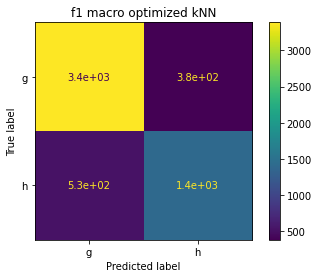

------------------------------------------------------------


In [ ]:
knn_macro_preds, times['f1 macro optimized kNN'] = train_best_time_and_predict(knn_macro, train, train_labels, test)

knn_best_predictions['f1 macro optimized kNN'] = knn_macro_preds

plot_confusion_matrix_and_scores(knn_best_predictions, test_labels, disp_labels)

Και εδώ, είχαμε λίγες υπερπαραμέτρους προς βελτιστοποίηση οπότε δε χρειάστηκε να τρέξουμε πολλά διαδοχικά GridSearch. Και για τις 2 μετρικές, το πρώτο GridSearch έγινε με παραμέτρους:

```
k = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
metric = [euclidean, chebyshev, manhattan, minkowski (μόνο για power=3)]
weights = [uniform, distance]
```

Με τα αποτελέσματα που βγήκαν μπορέσαμε να αποκλείσουμε εύκολα την απόσταση minkowski με δύναμη 3 από ένα βέλτιστο setup. Περιορίσαμε τους γείτονες στις τιμές που φαίνονται παραπάνω μιας και είδαμε ότι βγήκαν βέλτιστες οι παραμετροποιήσεις για k=[10,20] (και η 30 ήταν κόντα μόνο για την f1 macro), ώστε να πάρουμε μια τελική βέλτιστη παραμετροποίηση για κάθε μετρική με νέα Grid Searches.


### MLP Optimization

In [ ]:
scaler = StandardScaler()
clf = MLPClassifier(activation='relu', solver='adam')
pca = PCA()
layer_sizes = [200, 300, 400]
max_iter = [150, 200, 250, 300]
alpha = [1e-4, 1e-6, 1e-8]

parameters = {
    'mlp__hidden_layer_sizes': layer_sizes,
    'mlp__max_iter': max_iter,
    'mlp__alpha' : alpha
}

pipe_micro = Pipeline(steps=[('scaler', scaler),('pca', pca), ('mlp', clf)], memory = 'tmp')
mlp_micro = GridSearchCV(pipe_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
mlp_micro.fit(train, train_labels)
print(mlp_micro.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 43

{'mlp__alpha': 1e-06, 'mlp__hidden_layer_sizes': 400, 'mlp__max_iter': 200}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
mlp_micro_preds, times['f1 micro optimized MLP'] = train_best_time_and_predict(mlp_micro, train, train_labels, test)

mlp_best_predictions = {
    'f1 micro optimized MLP' : mlp_micro_preds
}

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
scaler = StandardScaler()
clf = MLPClassifier(activation='relu', solver='adam')
pca = PCA()
rus = RandomUnderSampler()

layer_sizes = [200, 250, 300]
max_iter = [200, 250, 300]
alpha = [1e-4, 1e-6, 1e-8]

parameters = {
    'mlp__hidden_layer_sizes': layer_sizes,
    'mlp__max_iter': max_iter,
    'mlp__alpha' : alpha
}

pipe_macro = Pipeline(steps=[('scaler', scaler), ('sampler', rus), ('pca', pca), ('mlp', clf)], memory = 'tmp')
mlp_macro = GridSearchCV(pipe_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
mlp_macro.fit(train, train_labels)
print(mlp_macro.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 29

{'mlp__alpha': 1e-06, 'mlp__hidden_layer_sizes': 250, 'mlp__max_iter': 250}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



f1-micro average for f1 micro optimized MLP : 0.8783736417805819
f1-macro average for f1 micro optimized MLP : 0.8594441604906722
Classification report:
              precision    recall  f1-score   support

           g       0.88      0.94      0.91      3768
           h       0.87      0.75      0.81      1938

    accuracy                           0.88      5706
   macro avg       0.88      0.85      0.86      5706
weighted avg       0.88      0.88      0.88      5706



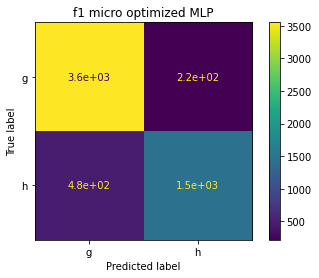

------------------------------------------------------------

f1-micro average for f1 macro optimized MLP : 0.8633017875920084
f1-macro average for f1 macro optimized MLP : 0.849036969098349
Classification report:
              precision    recall  f1-score   support

           g       0.90      0.89      0.90      3768
           h       0.79      0.82      0.80      1938

    accuracy                           0.86      5706
   macro avg       0.85      0.85      0.85      5706
weighted avg       0.86      0.86      0.86      5706



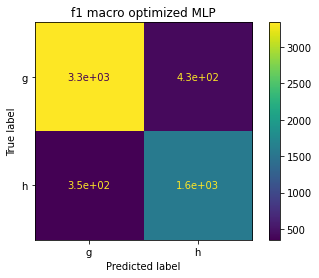

------------------------------------------------------------


In [ ]:
mlp_macro_preds, times['f1 macro optimized MLP'] = train_best_time_and_predict(mlp_macro, train, train_labels, test)

mlp_best_predictions['f1 macro optimized MLP'] = mlp_macro_preds

plot_confusion_matrix_and_scores(mlp_best_predictions, test_labels, disp_labels)

Για τη βελτιστοποιήση του MLP χρειάστηκε να κάνουμε παραπάνω δοκιμές. Αρχικά θα αναλύσουμε την προσέγγισή μας στη βελτιστοποιήση του MLP ως προς f1 micro. Καταρχάς, σημειώνουμε ότι όλα τα GridSearches εκτός από αυτά που φαίνονται παραπάνω έγιναν έχοντας πάρει 1000 δείγματα από το αρχικό dataset, εφόσον σε αντίθετη περίπτωση θα ήταν εξαιρετικά χρονοβόρα.

Το αρχικό GridSearch είχε παραμέτρους:

```
layer_sizes = [100, 500, 700]
max_iter = [100, 200, 500, 1000]
solver = [adam, sgd]
learning_rate = [invscaling, constant, adaptive]
activation = [relu,logistic,identity,tanh]
alpha = [1e-2, 1e-4, 1e-6]
```

Από αυτό το GridSearch και τα αναλυτικά του αποτελέσματα, μπορέσαμε να περιορίσουμε το solver στον adam, να πετάξουμε τελείως το learning_rate (αφού ο adam δε χρησιμοποιεί) και επίσης να αποκλείσουμε τις συναρτήσεις identity και tanh. Βέλτιστες τιμές για τα layer_sizes και το max_iter βγήκαν στους top συνδυασμούς οι τιμές 500, 200 αντίστοιχα. Τέλος, για το alpha είδαμε ότι προτιμούνται οι μικρότερες τιμές. Επομένως τρέξαμε 2ο GridSearch με παραμέτρους:

```
layer_sizes = [300, 500, 700]
max_iter = [100, 200, 300]
activation = [relu,tanh]
alpha = [1e-4, 1e-6, 1e-8]
```

Σε αυτό το GridSearch είδαμε ότι η συνάρτηση ενεργοποίησης relu έκανε outperform αρκετά τη συνάρτηση tanh για όλες τις αντίστοιχες τους παραμετροποιήσεις. Επίσης, είδαμε ότι οι τιμές max_iter = [200,300] είχαν καλύτερη επίδοση από το 100 και ότι η βέλτιστη τιμή των layer_sizes έγινε πλέον 300 αλλά με μικρή διαφορά από το 500. Έτσι, τρέξαμε την GridSearch που βλέπουμε παραπάνω και πήραμε ικανοποιητικά αποτελέσματα.

Τώρα θα αναλύσουμε την προσέγγιση για τη βελτιστοποίηση του f1 macro MLP. Το πρώτο μας GridSearch είχε παραμέτρους ίδιες με τις παραμέτρους του 1ου f1 micro GridSearch, και παρόμοια αποτελέσματα, πλην όμως η παράμετρος layer_sizes έτεινε προς μικρότερες τιμές με καλύτερα αποτελέσματα για την τιμή 100. Επομένως χρησιμοποιήσαμε τις παρακάτω υπερπαραμέτρους για το 2ο GridSearch:

```
layer_sizes = [100, 200, 400]
max_iter = [100, 200, 300]
activation = [relu,tanh]
alpha = [1e-4, 1e-6, 1e-8]
```

Όπως και για την άλλη μετρική, είδαμε ότι όταν είμαστε κοντά στις βέλτιστες υπερπαραμέτρους η συνάρτηση relu κάνει outperform τη συνάρτηση tanh. Επίσης, είδαμε ότι για την τιμή layer_sizes προτιμήθηκε το 200 και για την τιμή max_iter επίσης το 200. Θα μπορούσαμε να είχαμε σταματήσει εδώ, αλλά το GridSearch είχε τρέξει για το sampled training set, επομένως τρέξαμε άλλο ένα GridSearch (αυτό που φαίνεται παραπάνω) με πιο στενές τιμές για τις υπερπαραμέτρους.

### SVM's Optimization

In [ ]:
###LINEAR MICRO###

scaler = StandardScaler()
clf = LinearSVC(dual=False)
pca = PCA() 


C = [0.01, 0.1, 1, 10, 100]
loss = ['squared_hinge']
tol = [1e-4, 1e-5, 1e-6]
penalty = ['l1', 'l2']
class_weight = [None, 'balanced']
parameters = {
    'svc__C': C,
    'svc__loss' : loss,
    'svc__tol' : tol,
    'svc__penalty': penalty,
    'svc__class_weight' : class_weight
}
pipe_linear_micro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_linear_micro = GridSearchCV(pipe_linear_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
svc_linear_micro.fit(train, train_labels)
print(svc_linear_micro.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

{'svc__C': 1, 'svc__class_weight': None, 'svc__loss': 'squared_hinge', 'svc__penalty': 'l1', 'svc__tol': 0.0001}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.5s finished


In [ ]:
svc_linear_micro_preds, times['f1 micro optimized linear SVC'] = train_best_time_and_predict(svc_linear_micro, train, train_labels, test)

svc_best_predictions = {
    'f1 micro optimized linear SVC' : svc_linear_micro_preds
}

In [ ]:
###LINEAR MACRO###
scaler = StandardScaler()
clf = LinearSVC(dual=False)
pca = PCA()

penalty = ['l1', 'l2']
C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
loss = ['squared_hinge']
tol = [1e-4, 1e-5, 1e-6]
class_weight = [None, 'balanced']

parameters = {
    'svc__C': C,
    'svc__loss' : loss,
    'svc__tol' : tol,
    'svc__penalty': penalty,
    'svc__class_weight': class_weight
}
pipe_linear_macro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_linear_macro = GridSearchCV(pipe_linear_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
svc_linear_macro.fit(train, train_labels)
print(svc_linear_macro.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

{'svc__C': 0.001, 'svc__class_weight': 'balanced', 'svc__loss': 'squared_hinge', 'svc__penalty': 'l2', 'svc__tol': 0.0001}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.3s finished


In [ ]:
svc_linear_macro_preds, times['f1 macro optimized linear SVC'] = train_best_time_and_predict(svc_linear_macro, train, train_labels, test)

svc_best_predictions['f1 macro optimized linear SVC'] = svc_linear_macro_preds

In [ ]:
###POLY MICRO###
scaler = StandardScaler()
pca = PCA()
clf = SVC(kernel='poly')

C = [200, 300, 400]
degree = [3]
gamma = ['scale','auto']
tol = [1e-1, 1e-3]

parameters = {
    'svc__C' : C,
    'svc__degree' : degree,
    'svc__gamma' : gamma,
    'svc__tol' : tol
}

pipe_poly_micro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_poly_micro = GridSearchCV(pipe_poly_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
svc_poly_micro.fit(train, train_labels)
print(svc_poly_micro.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 39.8min finished


{'svc__C': 400, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__tol': 0.1}


In [ ]:
svc_poly_micro_preds, times['f1 micro optimized poly SVC'] = train_best_time_and_predict(svc_poly_micro, train, train_labels, test)

svc_best_predictions['f1 micro optimized poly SVC'] = svc_poly_micro_preds

In [ ]:
###POLY MACRO###
scaler = StandardScaler()
pca = PCA()
clf = SVC(kernel='poly', class_weight='balanced')

C = [50, 100, 200]
degree = [2,3]
gamma = ['scale', 'auto']
tol = [1e-2, 1e-3, 1e-4]

parameters = {
    'svc__C' : C,
    'svc__degree' : degree,
    'svc__gamma' : gamma,
    'svc__tol' : tol
}

pipe_poly_macro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_poly_macro = GridSearchCV(pipe_poly_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
svc_poly_macro.fit(train, train_labels)
print(svc_poly_macro.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 27

{'svc__C': 200, 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__tol': 0.01}


In [ ]:
svc_poly_macro_preds, times['f1 macro optimized poly SVC'] = train_best_time_and_predict(svc_poly_macro, train, train_labels, test)

svc_best_predictions['f1 macro optimized poly SVC'] = svc_poly_macro_preds

In [ ]:
###RBF MICRO###
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

scaler = StandardScaler()
pca = PCA()
clf = SVC(kernel='rbf')

C = [50,100,200]
gamma = ['scale', 'auto']
tol = [1e-2, 1e-3, 1e-4]

parameters = {
    'svc__C' : C,
    'svc__gamma' : gamma,
    'svc__tol' : tol
}

pipe_rbf_micro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_rbf_micro = GridSearchCV(pipe_rbf_micro, parameters, cv=5, scoring='f1_micro', verbose=10, n_jobs=-1)
svc_rbf_micro.fit(train, train_labels)
print(svc_rbf_micro.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.5min finished


{'svc__C': 50, 'svc__gamma': 'scale', 'svc__tol': 0.001}


In [ ]:
svc_rbf_micro_preds, times['f1 micro optimized rbf SVC'] = train_best_time_and_predict(svc_rbf_micro, train, train_labels, test)

svc_best_predictions['f1 micro optimized rbf SVC'] = svc_rbf_micro_preds

In [ ]:
###RBF MACRO###
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

scaler = StandardScaler()
pca = PCA()
clf = SVC(kernel='rbf', class_weight='balanced')

C = [1, 5, 10, 50]
gamma = ['scale', 'auto']
tol = [1e-2, 1e-3, 1e-4]

parameters = {
    'svc__C' : C,
    'svc__gamma' : gamma,
    'svc__tol' : tol
}

pipe_rbf_macro = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', clf)], memory = 'tmp')
svc_rbf_macro = GridSearchCV(pipe_rbf_macro, parameters, cv=5, scoring='f1_macro', verbose=10, n_jobs=-1)
svc_rbf_macro.fit(train, train_labels)
print(svc_rbf_macro.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.4min finished


{'svc__C': 50, 'svc__gamma': 'scale', 'svc__tol': 0.0001}



f1-micro average for f1 micro optimized linear SVC : 0.7933753943217665
f1-macro average for f1 micro optimized linear SVC : 0.7550510047793895
Classification report:
              precision    recall  f1-score   support

           g       0.81      0.90      0.85      3768
           h       0.75      0.59      0.66      1938

    accuracy                           0.79      5706
   macro avg       0.78      0.74      0.76      5706
weighted avg       0.79      0.79      0.79      5706



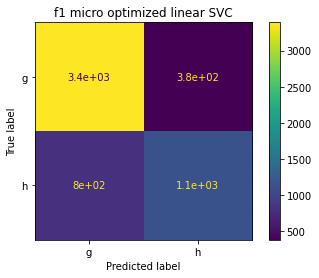

------------------------------------------------------------

f1-micro average for f1 macro optimized linear SVC : 0.7933753943217665
f1-macro average for f1 macro optimized linear SVC : 0.7705129842961762
Classification report:
              precision    recall  f1-score   support

           g       0.85      0.84      0.84      3768
           h       0.69      0.70      0.70      1938

    accuracy                           0.79      5706
   macro avg       0.77      0.77      0.77      5706
weighted avg       0.79      0.79      0.79      5706



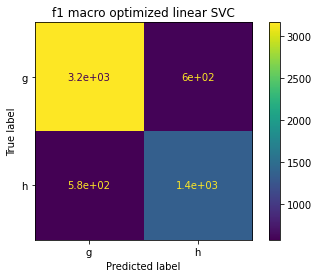

------------------------------------------------------------

f1-micro average for f1 micro optimized rbf SVC : 0.8722397476340694
f1-macro average for f1 micro optimized rbf SVC : 0.8506142980862588
Classification report:
              precision    recall  f1-score   support

           g       0.87      0.95      0.91      3768
           h       0.88      0.72      0.79      1938

    accuracy                           0.87      5706
   macro avg       0.87      0.84      0.85      5706
weighted avg       0.87      0.87      0.87      5706



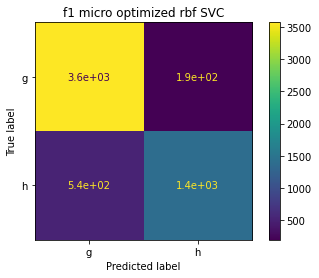

------------------------------------------------------------

f1-micro average for f1 macro optimized poly SVC : 0.8361373992288818
f1-macro average for f1 macro optimized poly SVC : 0.8165851527384441
Classification report:
              precision    recall  f1-score   support

           g       0.87      0.88      0.88      3768
           h       0.76      0.75      0.76      1938

    accuracy                           0.84      5706
   macro avg       0.82      0.82      0.82      5706
weighted avg       0.84      0.84      0.84      5706



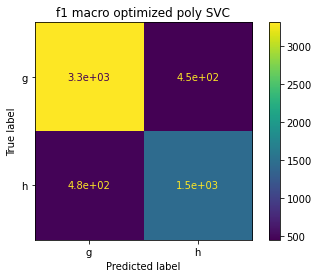

------------------------------------------------------------

f1-micro average for f1 micro optimized poly SVC : 0.8338590956887487
f1-macro average for f1 micro optimized poly SVC : 0.7961553071413067
Classification report:
              precision    recall  f1-score   support

           g       0.82      0.96      0.88      3768
           h       0.88      0.59      0.71      1938

    accuracy                           0.83      5706
   macro avg       0.85      0.78      0.80      5706
weighted avg       0.84      0.83      0.82      5706



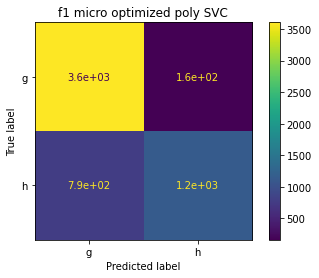

------------------------------------------------------------

f1-micro average for f1 macro optimized rbf SVC : 0.8687346652646337
f1-macro average for f1 macro optimized rbf SVC : 0.8526159363096348
Classification report:
              precision    recall  f1-score   support

           g       0.89      0.91      0.90      3768
           h       0.82      0.79      0.80      1938

    accuracy                           0.87      5706
   macro avg       0.86      0.85      0.85      5706
weighted avg       0.87      0.87      0.87      5706



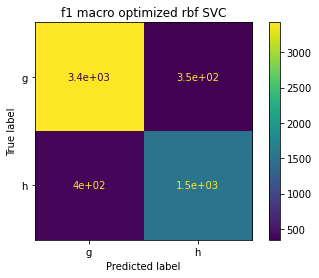

------------------------------------------------------------


In [ ]:
svc_rbf_macro_preds, times['f1 macro optimized rbf SVC'] = train_best_time_and_predict(svc_rbf_macro, train, train_labels, test)

svc_best_predictions['f1 macro optimized rbf SVC'] = svc_rbf_macro_preds

plot_confusion_matrix_and_scores(svc_best_predictions, test_labels, disp_labels)

Θα αναλύσουμε τις προσεγγίσεις μας για όλα τα SVM's με τη σειρά που εμφανίζονται στα κελιά.

Για τα linearSVC's δεν χρειάστηκε πολλή δουλειά. Το documentation της βιβλιοθήκης sklearn προτείνει ισχυρά να θέσουμε dual=False όταν n_samples > n_features (κάτι που εδώ ισχύει στο έπακρο), η οποία ρύθμιση δε δέχεται για loss function την hinge. Έτσι, είπαμε να πειραματιστούμε με το penalty. Κατά τα άλλα, δοκιμάσαμε στο πρώτο GridSearch για το C τις τιμές:

```
C = [1,10,100,1000]
```

(μαζί με τις υπόλοιπες υπερπαραμέτρους που φαίνονται και παραπάνω) και επειδή και στις 2 μετρικές βγήκε βέλτιστο το C=1, δοκιμάσαμε τις τιμές που φαίνονται στα παραπάνω Grid Searches, στα οποία πήραμε ικανοποιητικά αποτελέσματα.

Για τα polySVC's δοκιμάσαμε αρχικά και για τις 2 μετρικές το εξής GridSearch: 

```
C= [1,10,50,100]
degree=[1,2,3,4,5]
gamma=[scale,auto]
tol=[1e-1, 1e-3, 1e-5]
```

Είδαμε και για τις 2 μετρικές ότι τα degrees = [2,3] είναι καλύτερα από τα υπόλοιπα, αλλά και ότι το C = 100 ήταν βέλτιστο και στις 2 περιπτώσεις.

Επομένως τρέξαμε και για τις 2 μετρικές ίδιο 2ο GridSearch:

```
C=[50,100,200]
degree=[2,3]
gamma=[scale,auto]
tol=[1e-1, 1e-3, 1e-5]
```

Εδώ λάβαμε κατευθείαν ικανοποιητικά αποτελέσματα για τη μετρική macro, ενώ για την μετρική micro προτιμήσαμε να τρέξουμε ένα ακόμα GridSearch με τις τιμές που φαίνονται παραπάνω (έχοντας δει παράλληλα ότι το degree=3 είναι αρκετά καλύτερο από το degree=2). 

Για τους πυρήνες rbf δοκιμάσαμε το εξής 1ο GridSearch:

```
C=[1,5,10,50]
gamma=[scale,auto]
tol=[1e-2, 1e-3, 1e-4]
```

Εδώ λάβαμε κατευθείαν ικανοποιητικά αποτελέσματα για την μετρική f1 macro (αυτά που βλέπουμε παραπάνω), ενώ για τη μετρική micro επειδή βγήκε βέλτιστο C=50 τρέξαμε το GridSearch που φαίνεται παραπάνω, στο οποίο πήραμε ικανοποιητικά αποτελέσματα.

### Συνολικά αποτελέσματα και σχολιασμός

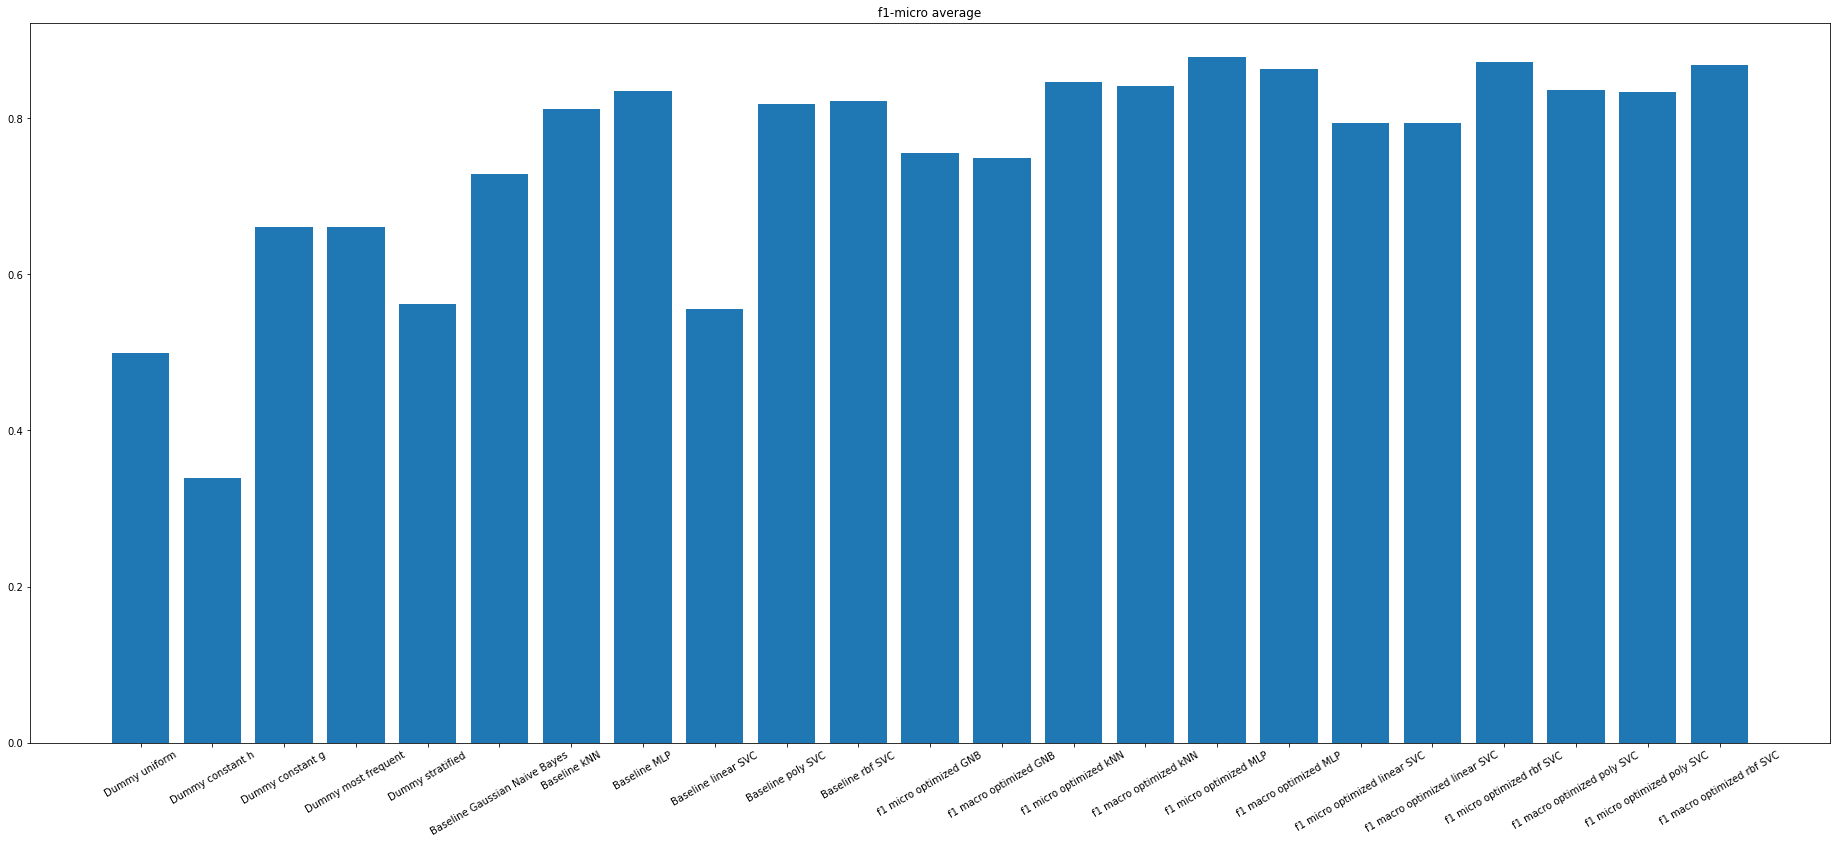

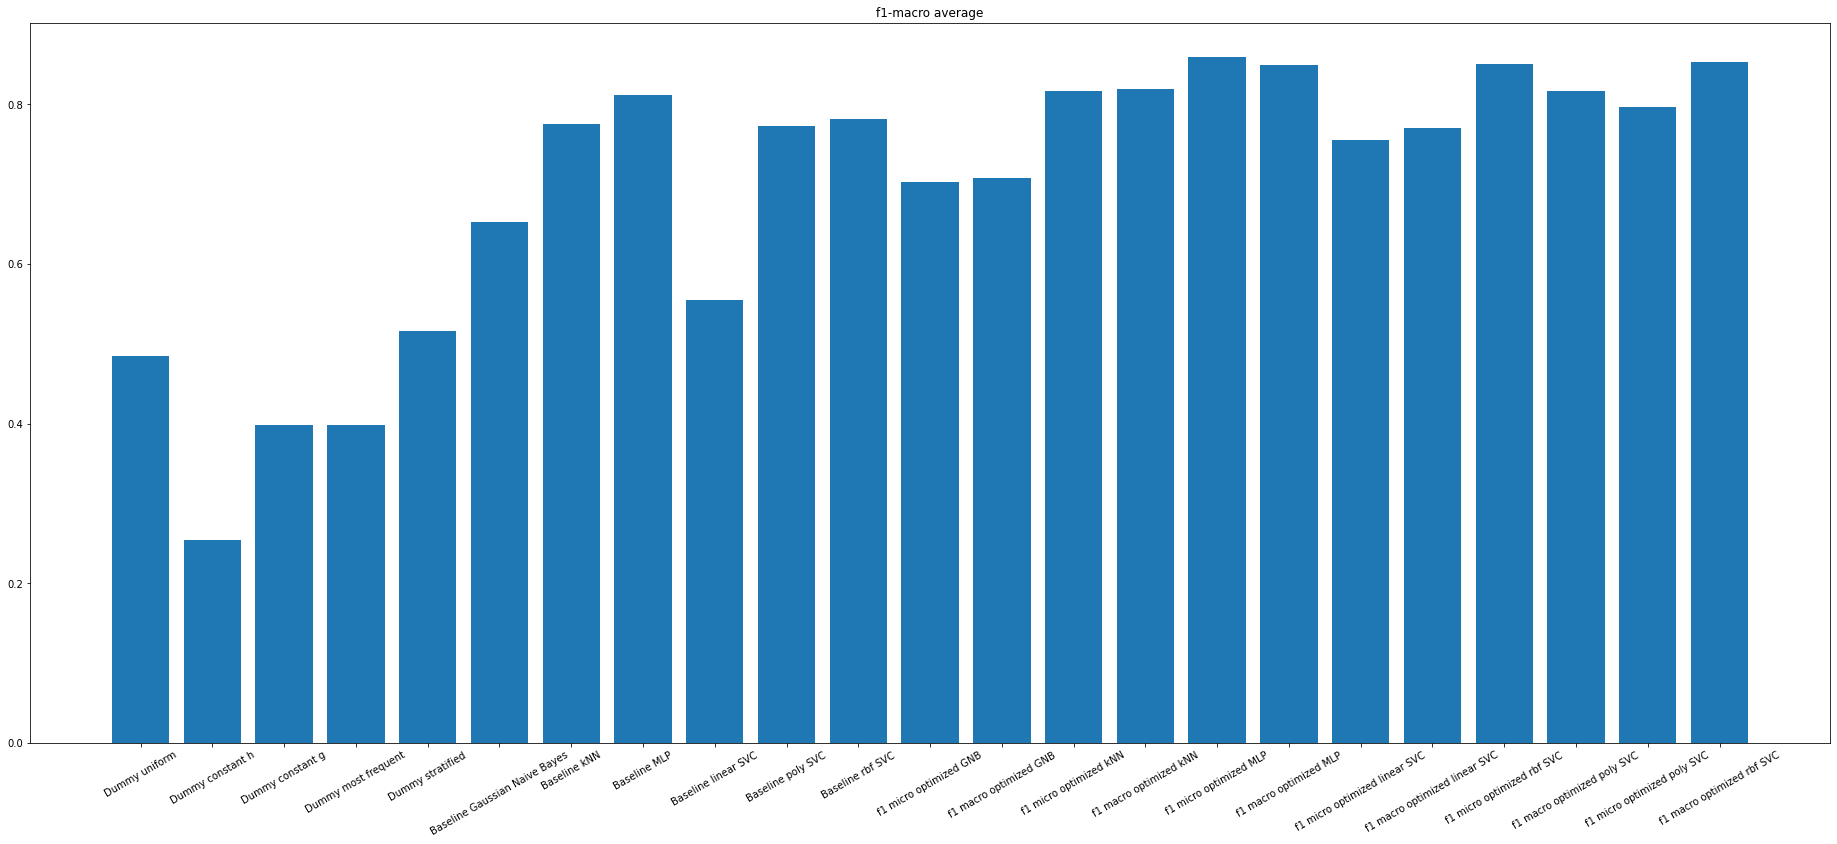

In [ ]:
for d in gnb_best_predictions, knn_best_predictions, mlp_best_predictions, svc_best_predictions:
  bar_plot_predictions.update(d)

print_bar_plots(bar_plot_predictions, test_labels, 'micro', size=(25,10))
print_bar_plots(bar_plot_predictions, test_labels, 'macro', size=(25,10))

Από τα παραπάνω plots και τους πίνακες σύγχυσης, βγάζουμε τα εξής συμπεράσματα:


*   Λόγω του μεγάλου μεγέθους του dataset, μπορέσαμε να βελτιώσουμε κατά πολύ όλους τους ταξινομητές. Ενδεικτικά ο linear SVC που αρχικοποιημένος έδειχνε χειρότερος από τους dummy, "έπιασε" 0.8 f1 micro και 0.77 f1 macro.
*   Παρόλο που αυξήσαμε κατά πολύ τις μετρικές, τα recall της κλάσης h παραμένουν σχετικά μέτρια. Αξιοσημείωτο είναι ότι το f1 macro optimized MLP δεν έχει τόσο καλές μετρικές όσο το f1 micro optimized MLP αλλά έχει αρκετά καλύτερο recall στην κλάση h.
*   Αντιθέτως, πετυχαίνουμε πολύ υψηλά scores όσον αφορά στο precision και το recall της κλάσης g. Αυτό ήταν αναμενόμενο ειδικά για τους f1 micro optimized classifiers αφού εκπαιδεύονταν πάνω σε ένα μη ισορροπημένο dataset.



In [ ]:
#Plot times
pd.DataFrame.from_dict(times, orient='index', columns=['times (seconds)'])

,times (seconds)
f1 micro optimized GNB,0.125180
f1 macro optimized GNB,0.193265
f1 micro optimized kNN,0.536447
f1 macro optimized kNN,0.767483
f1 micro optimized MLP,48.817098
f1 macro optimized MLP,30.487573
f1 micro optimized linear SVC,0.123108
f1 macro optimized linear SVC,0.140911
f1 micro optimized rbf SVC,8.753568
f1 macro optimized poly SVC,40.314320


Για τους χρόνους σε σχέση με την επίδοση βλέπουμε 3 αξιοσημείωτα πράγματα:


*   Το kNN μας δίνει πολύ καλά αποτελέσματα σε πρακτικά μηδενικό χρόνο εκπαίδευσης-πρόβλεψης
*   Το MLP παρότι ακριβό ως προς το χρόνο που χρειάζεται να εκπαιδευτεί, μας δίνει τα καλύτερα αποτελέσματα μαζί με το rbf SVC, το οποίο όμως είναι σχετικά γρήγορο στην εκπαίδευση (τουλάχιστον για τις βέλτιστες υπερπαραμέτρους του)
*   To poly SVC είναι πολύ ακριβό στην εκπαίδευση και μας έδωσε χειρότερα αποτελέσματα και από το MLP και από το rbf SVC αλλά και απο το kNN.



In [ ]:
#Plot performance differences
performance_dict = {
    'GNB': [gnb_base_preds, gnb_micro_preds, gnb_macro_preds],
    'kNN': [knn_base_preds, knn_micro_preds, knn_macro_preds],
    'MLP': [mlp_base_preds, mlp_micro_preds, mlp_macro_preds],
    'linear SVC': [svc_linear_base_preds, svc_linear_micro_preds, svc_linear_macro_preds],
    'poly SVC': [svc_poly_base_preds, svc_poly_micro_preds, svc_poly_macro_preds],
    'rbf SVC': [svc_rbf_base_preds, svc_rbf_micro_preds, svc_rbf_macro_preds]
}

In [ ]:
#We want to change the dictionary values, so we copy the original to make sure it's not lost
performance_micro = copy.deepcopy(performance_dict)
change_preds_to_scores(performance_micro, test_labels, 'micro')
print("f1 micro scores before and after:")
pd.DataFrame.from_dict(performance_micro, orient='index', columns=['Baseline', 'f1 micro optimized', 'f1 macro optimized'])

f1 micro scores before and after:


,Baseline,f1 micro optimized,f1 macro optimized
GNB,0.728882,0.755696,0.748861
kNN,0.811952,0.846828,0.841395
MLP,0.834735,0.878374,0.863302
linear SVC,0.555906,0.793375,0.793375
poly SVC,0.817560,0.833859,0.836137
rbf SVC,0.822292,0.872240,0.868735


In [ ]:
#We want to change the dictionary values, so we copy the original to make sure it's not lost
performance_macro = copy.deepcopy(performance_dict)
change_preds_to_scores(performance_macro, test_labels, 'macro')
print("f1 macro scores before and after:")
pd.DataFrame.from_dict(performance_macro, orient='index', columns=['Baseline', 'f1 micro optimized', 'f1 macro optimized'])

f1 macro scores before and after:


,Baseline,f1 micro optimized,f1 macro optimized
GNB,0.653095,0.702759,0.707260
kNN,0.774977,0.816679,0.819758
MLP,0.811667,0.859444,0.849037
linear SVC,0.555119,0.755051,0.770513
poly SVC,0.773310,0.796155,0.816585
rbf SVC,0.781964,0.850614,0.852616


Και εδώ βλέπουμε ότι έχουμε βελτιώσει αισθητά τους classifiers μας μέσα από την βελτιστοποίηση υπερπαραμέτρων, με τον πιο αξιοσημείωτο classifier να είναι ο LinearSVC που πριν τη βελτιστοποίηση είχε χειρότερη επίδοση και από τους dummy. Επίσης βλέπουμε ότι έχουμε επιτύχει πολύ καλές επιδόσεις, ιδιαίτερα στον MLP που πλησιάζει 0.88 ακρίβεια και έχοντας σχεδόν το ίδιο f1 macro.